In [1]:
import os
import cv2
import warnings
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import jaccard_similarity_score


warnings.filterwarnings('ignore')
DAT_PATH = 'dataset/'
TARGET = 'MAP'

random_seed = 42

CHANNELS_PATCHGAN = 6

IMG_WIDTH = 256
IMG_HEIGHT = 256

BATCH_SIZE = 16

n= 800  # CANTIDAD DE IMAGENES TRAIN + TEST
n_split= 0.75 # DIVISION  75% PARA TRAIN Y 25% PARA TEST
n_epochs = 100


In [2]:
!nvidia-smi

Fri Dec  6 06:26:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:03:00.0  On |                  N/A |
| 46%   38C    P8     7W / 105W |    682MiB /  8118MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   37C    P2    33W / 215W |      2MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
targets = ['seg','streaks','globules','milia','pigment','negatives']

map_targets ={'seg':0,'streaks':1,'globules':2,'milia':3,'pigment':4,'negatives':5}

CHANNELS = len(targets)
REPATH = 'results/'
INPATH = DAT_PATH+'IMAGES/'
OUPATH = DAT_PATH+TARGET+'/'
REPATHCK = REPATH+'checkpoints_'+TARGET+'/'
REPATHOU = REPATH+'output_'+TARGET+'/'
#imgurls = os.listdir(INPATH)
imgurls = [os.path.splitext(filename)[0] for filename in os.listdir(INPATH)]
print(imgurls[:2])
imgurls.sort()
print(imgurls[:2])

jaccard_index_total =[]
train_n = round(n*0.75)

#listado randomizado

randurls = np.copy(imgurls)

np.random.seed(random_seed) # importante 
np.random.shuffle(randurls)

#particion train/test

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls),len(tr_urls),len(ts_urls))

['ISIC_0010602', 'ISIC_0000199']
['ISIC_0000001', 'ISIC_0000003']
823 600 200


In [4]:
n_ = [0,1,2]+[i*BATCH_SIZE for i in [1,2,3]]
ts_urls[n_]

array(['ISIC_0000407', 'ISIC_0014951', 'ISIC_0000487', 'ISIC_0012268',
       'ISIC_0013244', 'ISIC_0011330'], dtype='<U12')

In [5]:
def create_folder(path,name):
    import os
    try:
        path=path+name
        os.mkdir(path)
    except OSError:
        print ("Exist or Failed the directory %s" % path)
    else:
        print ("Successfully created the directory %s " % path)

In [6]:
create_folder(REPATHOU+'example_images','')
create_folder(REPATHOU+'example_maps','')
for file_name in ts_urls[n_]:
    create_folder(REPATHOU+'example_images/'+file_name,'')
    create_folder(REPATHOU+'example_maps/'+file_name,'')

Exist or Failed the directory results/output_MAP/example_images
Successfully created the directory results/output_MAP/example_maps 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0000407
Successfully created the directory results/output_MAP/example_maps/ISIC_0000407 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0014951
Successfully created the directory results/output_MAP/example_maps/ISIC_0014951 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0000487
Successfully created the directory results/output_MAP/example_maps/ISIC_0000487 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0012268
Successfully created the directory results/output_MAP/example_maps/ISIC_0012268 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0013244
Successfully created the directory results/output_MAP/example_maps/ISIC_0013244 
Exist or Failed the directory results/output_MAP/example_images/ISIC_0011330
S

In [7]:
def resize(inimg,tgimg,heigth,width):
    
    inimg = tf.image.resize(inimg,[heigth,width])
    tgimg = tf.image.resize(tgimg,[heigth,width])
    
    return inimg,tgimg
# normalizar las imagenes [-1 +1]

def normalize(inimg,tgimg):
    
    inimg = (inimg/127.5) -1
    
    tgimg = (tgimg/127.5) -1
    
    return inimg,tgimg



# Aumentacion de datos : Random Crop + Flip
@tf.function()
def random_jitter(inimg,tgimg):
    inimg , tgimg = resize(inimg,tgimg,IMG_WIDTH,IMG_HEIGHT)
    stacked_image = tf.stack([inimg,tgimg],axis=0)
    cropped_image = tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
    
    if( tf.random.uniform(())>0.5):
        cropped_image = tf.image.flip_left_right(cropped_image)
    inimg,tgimg = cropped_image[0],cropped_image[1]
    
    return inimg,tgimg

def load_images(filename, augment = True):
    
    inimg =  tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH+'/'+filename+'.jpg')),tf.float32)[..., :3]
    tgimg1 =  tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename+'_1.png')),tf.float32)[..., :3]
    tgimg2 =  tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename+'_2.png')),tf.float32)[..., :3]
    tgimg = tf.concat([tgimg1, tgimg2],2)
    inimg, tgimg = resize(inimg,tgimg,IMG_HEIGHT,IMG_WIDTH)
    inimg,tgimg = normalize(inimg,tgimg)

    return inimg,tgimg

def load_train_images(filename):
    return load_images(filename,True)
def load_test_images(filename):
    return load_images(filename,False)


def get_jaccard(epoch):
    
    mask_original=[]
    mask_predict =[]
    iou=[]
    for i in range(6):
        mask_predict.append([])
        mask_original.append([])
        #iou.apppend([])
    #print(n_epoch)
    
    #REPATHOU+name+save_filename+'_1.png',prediction[idx,:,:,:3])
    for idx, filename in enumerate(ts_urls):
        
        map_image1 = plt.imread(REPATHOU+filename+'_'+str(epoch)+'_1.png')
        os.remove(REPATHOU+filename+'_'+str(epoch)+'_1.png')
        map_image2 = plt.imread(REPATHOU+filename+'_'+str(epoch)+'_2.png')
        os.remove(REPATHOU+filename+'_'+str(epoch)+'_2.png')
        map_image =np.concatenate((map_image1, map_image2), axis=2)
        
        real_image = plt.imread(INPATH+'/'+filename+'.jpg')
        map_image_real1 = plt.imread(OUPATH+'/'+filename+'_1.png')
        map_image_real2 = plt.imread(OUPATH+'/'+filename+'_2.png')
        map_image_real =np.concatenate((map_image_real1, map_image_real2), axis=2)
        
        for j in range(CHANNELS):
            mask_predict[j].append(map_image[:,:,j]>0)
            mask_original[j].append(map_image_real[:,:,j]>0)


        if(idx<3):

            plt.figure(figsize=(60,8.5))
            
            display_list = [real_image,map_image_real1,map_image_real2,map_image1,map_image2]

            title = ['Real']+['Test Truth_'+str(f) for f in range(CHANNELS//3)]+['Test gen _'+str(f) for f in range(CHANNELS//3) ]
            title = [filename]+['Ground Truth_'+str(f) for f in range(CHANNELS//3)]+['Predicted Image_'+str(f) for f in range(CHANNELS//3) ]
            
            for i in range(len(display_list)):
                plt.subplot(1,len(display_list),i+1)
                plt.title(title[i], fontsize=40)
                # de -1 1 -->  a 0 1
                plt.imshow(display_list[i])
                plt.axis('off')
                
            plt.savefig(REPATHOU+'example_images/'+filename+'/'+filename+'_'+str(epoch))
            plt.show()

    for j in range(6):
        img_true=np.array(mask_original[j]).ravel()
        img_pred=np.array(mask_predict[j]).ravel()
        iou.append(jaccard_similarity_score(img_true, img_pred))
    #print(TARGET +': jaccard index  = ',iou)
    return iou

In [8]:
tf.__version__  # you should get 2.0.0-rc0

'2.0.0-rc0'

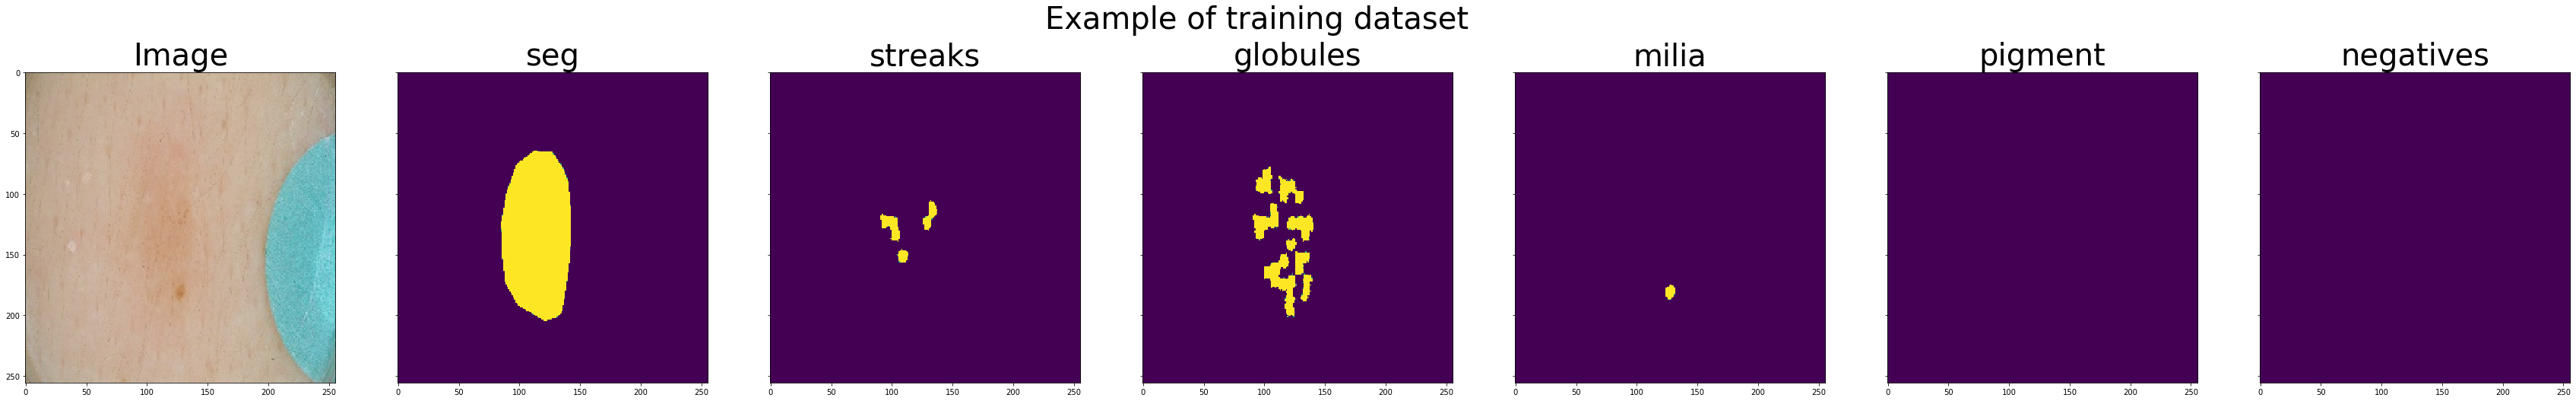

In [9]:
for idx in [3]:

    melanoma =load_train_images(randurls[idx])

    fig, axs = plt.subplots(1, CHANNELS+1, figsize=(60,8.5), sharey=True)
    axs[0].imshow((melanoma[0]+1)/2.0)
    axs[0].set_title('Image', fontdict={'fontsize': 40, 'fontweight': 'medium'})
    for i in range(CHANNELS):
        axs[i+1].imshow((melanoma[1][:,:,map_targets[targets[i]]]+1)/2.0)
        axs[i+1].set_title(targets[i], fontdict={'fontsize': 40, 'fontweight': 'medium'})
    fig.suptitle('Example of training dataset', fontsize=40)
    plt.savefig('images/'+TARGET+'_EXAMPLE_'+randurls[idx])

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset =  train_dataset.map(load_train_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset =  test_dataset.map(load_test_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)



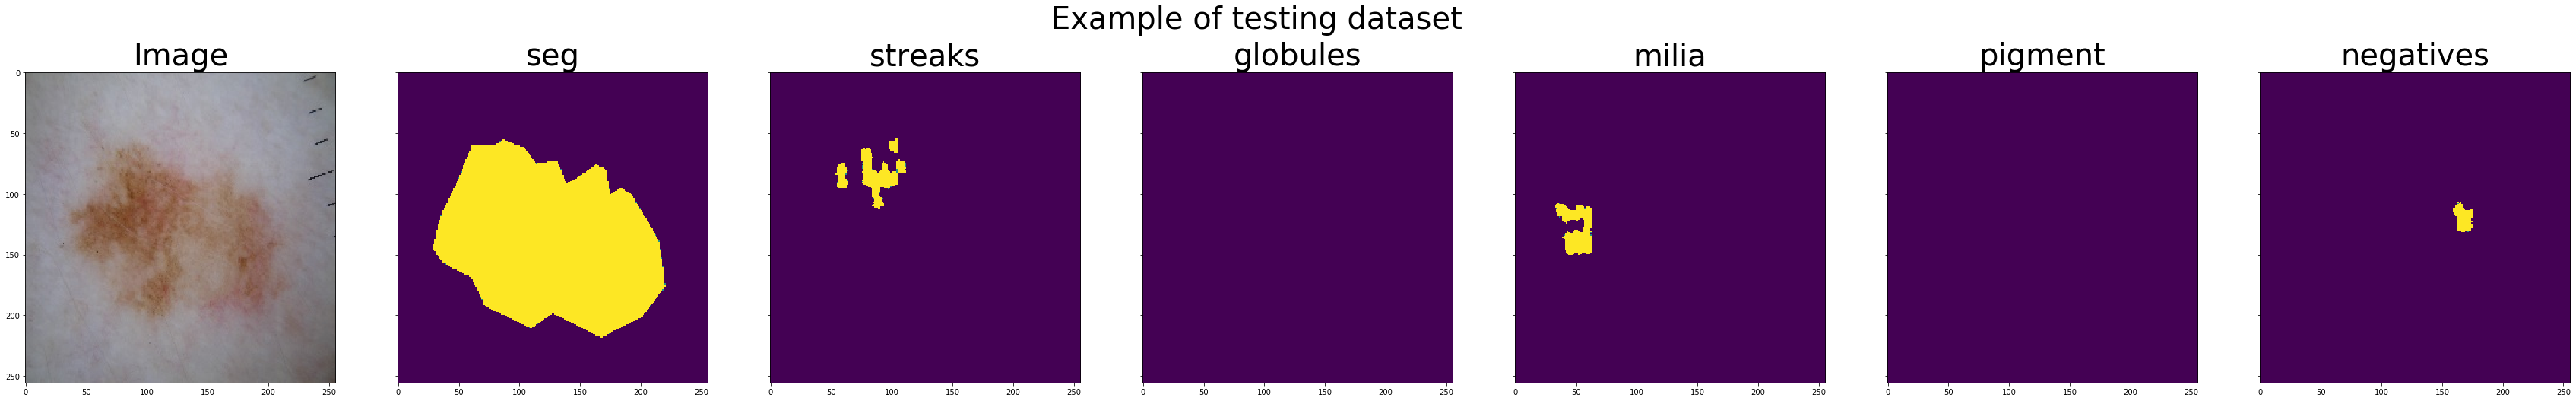

In [11]:
for inimg,tgimg in test_dataset.take(1):
    fig, axs = plt.subplots(1, CHANNELS+1, figsize=(60,8.5), sharey=True)
    axs[0].imshow((inimg[0]+1)/2.0)
    axs[0].set_title('Image', fontdict={'fontsize': 40, 'fontweight': 'medium'})
    for i in range(CHANNELS):
        axs[i+1].imshow((tgimg[0][:,:,map_targets[targets[i]]]+1)/2.0)
        axs[i+1].set_title(targets[i], fontdict={'fontsize': 40, 'fontweight': 'medium'})
fig.suptitle('Example of testing dataset', fontsize=40)
plt.savefig('images/'+TARGET+'_EXAMPLE_'+ts_urls[0])

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
def downsample(filters,apply_batchnorm=True):
     
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    # CApa de convolucion
    result.add(Conv2D(filters,
                      kernel_size=4,
                     strides =2,
                     padding ='same',
                     kernel_initializer=initializer,
                     use_bias=not apply_batchnorm))
    
    if apply_batchnorm:
        # CApa de batchnormalization
        result.add(BatchNormalization())

    # CApa de activación
    result.add(LeakyReLU())
    
    return result

downsample(64)

In [13]:
def upsample(filters,apply_dropout=False):
     
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    # Capa de convolucion
    result.add(Conv2DTranspose(filters,
                              kernel_size=4,
                             strides =2,
                             padding ='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    # Capa de batchnormalization
    result.add(BatchNormalization())
    
    if apply_dropout:
        # Capa de dropout
        result.add(Dropout(0.5))
        
    # Capa de activación
    result.add(ReLU())
    
    return result
upsample(64)

In [14]:
def Generator ():
    
    initializer = tf.random_normal_initializer(0,0.02)

    inputs =tf.keras.layers.Input(shape = [None,None,3])
    
    down_stack = [
                                                            #64 filtros --> 64 mapas de caracteristicas
        downsample(64,apply_batchnorm=False),  # (bs,128,128,64)  no se va aplicar el batch normalization 
        downsample(128),                       # (bs,64,64,128) 
        downsample(256),                       # (bs,32,32,256)
        downsample(512),                       # (bs,16,16,512)
        downsample(512),                       # (bs,8,8,512)
        downsample(512),                       # (bs,4,4,512)
        downsample(512),                       # (bs,2,2,512)
        downsample(512),                       # (bs,1,1,512)
    ]
    
    up_stack = [
        
        upsample(512,apply_dropout=True),       # (bs,2,2,1024)
        upsample(512,apply_dropout=True),       # (bs,4,4,1024)
        upsample(512,apply_dropout=True),       # (bs,8,8,1024)
        upsample(512),                          # (bs,16,16,1024)
        upsample(256),                          # (bs,32,32,512)  # No se va aplicar dropout
        upsample(128),                          # (bs,64,64,256)
        upsample(64),                           # (bs,128,128,128)
        
    ]
    
    last = Conv2DTranspose(filters= CHANNELS, # vamos a generar una imagen de n = CHANNELS
                           kernel_size=4,
                           strides = 2,
                           padding = 'same',
                           kernel_initializer = initializer,
                           activation = 'tanh' # porque nuestras imagenes de salida son de (-1 a 1)
                          )
    x= inputs
    
    s =  []  # lista de skip connections
    
    concat = Concatenate()
    
    for down in down_stack:
        x = down(x)
        s.append(x)
    
    s = reversed(s[:-1]) # no se toma el ultimo valor por ser un cuello de botella
    
    for up,sk in zip(up_stack,s):
        
        x = up(x)
        x = concat([x,sk])
        
    last = last(x)
    
    return Model(inputs=inputs,outputs=last)

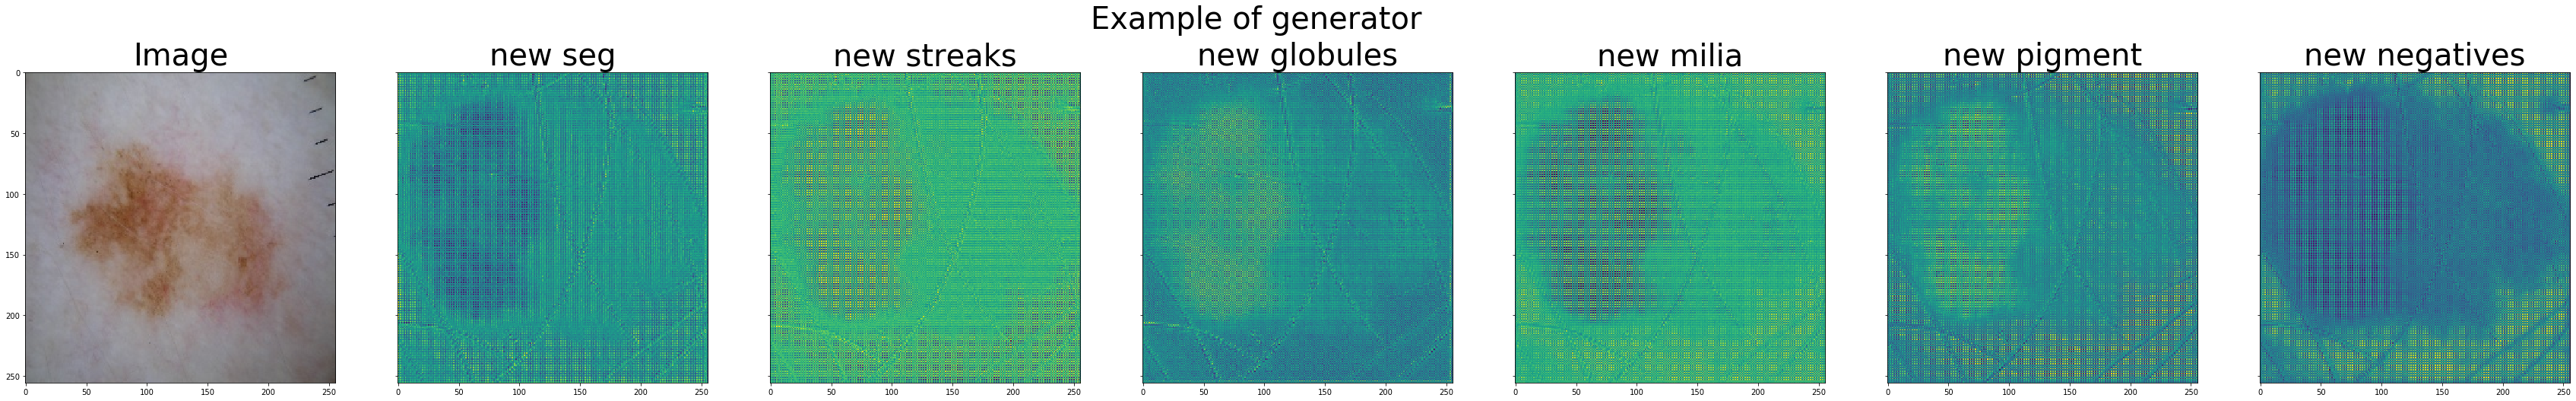

In [15]:
generator = Generator()
gen_output = generator(((tf.reshape(inimg[3],(1,IMG_WIDTH,IMG_HEIGHT,3)))), training = False)
#plt.imshow(gen_output[0,:,:,:3])
#plt.show()


fig, axs = plt.subplots(1, CHANNELS+1,  figsize=(60,8.5), sharey=True)
axs[0].imshow((inimg[0]+1)/2.0)
axs[0].set_title('Image', fontdict={'fontsize': 40, 'fontweight': 'medium'})
for i in range(CHANNELS):
    axs[i+1].imshow((gen_output[0][:,:,map_targets[targets[i]]]+1)/2.0)
    axs[i+1].set_title('new '+targets[i], fontdict={'fontsize': 40, 'fontweight': 'medium'})
fig.suptitle('Example of generator', fontsize=40)
plt.savefig('images/'+TARGET+'_EXAMPLE_GENERATOR_'+randurls[3])


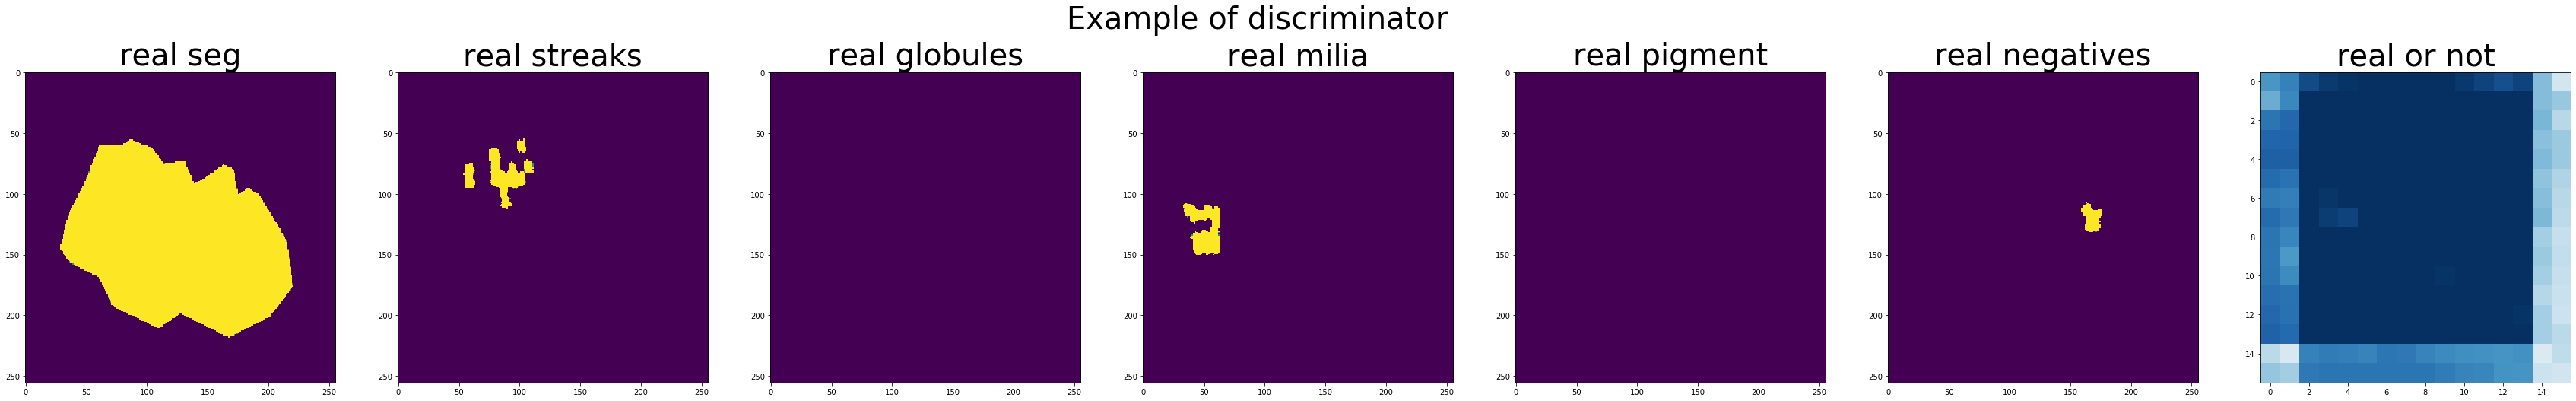

TensorShape([1, 16, 16, 6])

In [16]:
def Discriminator():
    
    ini = Input(shape = [None,None,3], name = "input_img")
    gen = Input(shape = [None,None,6], name = "gener_img")

    con = concatenate([ini,gen])  # [256,256,3]
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(216)(down2)
    down4 = downsample(512)(down3)
    
    last = tf.keras.layers.Conv2D(filters=CHANNELS_PATCHGAN,
                                 kernel_size=4,
                                 strides=1,
                                 kernel_initializer=initializer,
                                 padding = 'same')(down4)  # salida un unico canal que indica si es real o no
    
    return tf.keras.Model(inputs = [ini,gen],outputs = last)

discriminator = Discriminator()
disc_output = discriminator(([(tf.reshape(inimg[0],(1,IMG_WIDTH,IMG_HEIGHT,3))+1)*255,gen_output]), training = False)

plt.figure(figsize=(60,8.5))
plt.suptitle('Example of discriminator', fontsize=40)

for i in range(CHANNELS):
    plt.subplot(1, CHANNELS+1,i+1)
    plt.imshow((tgimg[0][:,:,map_targets[targets[i]]]+1)/2.0)
    plt.gca().set_title('real '+targets[i], fontdict={'fontsize': 40, 'fontweight': 'medium'})
    
plt.subplot(1,CHANNELS+1,CHANNELS+1)
plt.imshow(disc_output[0,...,-1],vmin=-20,vmax=20,cmap='RdBu_r')
plt.gca().set_title('real or not', fontdict={'fontsize': 40, 'fontweight': 'medium'})
plt.savefig('images/'+TARGET+'_EXAMPLE_DISCRIMINATOR_'+ts_urls[0])
plt.show()

disc_output.shape


In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits para aplicar la funcion sigmoide

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    # Diferencia entre los true por ser real y el detectado por el discriminador
    # lo idoneo seria obtener todo 1 que indica que todas las areas son reales
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    
    # Diferencia entre los false por ser generado y el detectado por el discriminador
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [19]:
LAMBDA = 100

# el mapa que ha generado el discriminador , la imagen que ha generado el generador y la imagen real 
def generator_loss(disc_generator_output, gen_output, target):
    
    # Diferencia entre los false por ser generado y el detectado por el discriminador
    gan_loss = loss_object(tf.ones_like(disc_generator_output),disc_generator_output)
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss +(LAMBDA*l1_loss)
    return total_gen_loss


In [20]:
import os

generator_optimizer  = tf.keras.optimizers.Adam(2e-4, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1= 0.5)

checkpoint_prefix = os.path.join(REPATHCK,'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator = discriminator)



In [21]:
def generate_images(epoch,model,test_input,tar,imgi,display_imgs=True):
    prediction = model(test_input, training = True)
    save_filenames = ts_urls[imgi*BATCH_SIZE:(imgi+1)*BATCH_SIZE]
    
    for idx,name in enumerate(save_filenames):
        tf.keras.preprocessing.image.save_img(REPATHOU+name+'_'+str(epoch)+'_1.png',prediction[idx,:,:,:3])
        tf.keras.preprocessing.image.save_img(REPATHOU+name+'_'+str(epoch)+'_2.png',prediction[idx,:,:,3:])
    
    if(imgi==0):
        for idy in [0,1,2]:
            for idx in range(CHANNELS):
                tf.keras.preprocessing.image.save_img(REPATHOU+'example_maps/'+save_filenames[idy]+'/'+save_filenames[idy]+'_'+str(epoch)+'_1.png',prediction[idy,:,:,:3])
                tf.keras.preprocessing.image.save_img(REPATHOU+'example_maps/'+save_filenames[idy]+'/'+save_filenames[idy]+'_'+str(epoch)+'_2.png',prediction[idy,:,:,3:])
        
    if(imgi>0 and imgi<4):
        plt.figure(figsize=(60,8.5))
        display_list = [test_input[0], tar[0,:,:,:3],tar[0,:,:,3:], prediction[0,:,:,:3],prediction[0,:,:,3:]]
        title = [save_filenames[0]]+['Ground Truth_'+str(f) for f in range(CHANNELS//3)]+['Predicted Image_'+str(f) for f in range(CHANNELS//3) ]
        for idx in range(CHANNELS):
            tf.keras.preprocessing.image.save_img(REPATHOU+'example_maps/'+save_filenames[0]+'/'+save_filenames[0]+'_'+str(epoch)+'_1.png',prediction[0,:,:,:3])
            tf.keras.preprocessing.image.save_img(REPATHOU+'example_maps/'+save_filenames[0]+'/'+save_filenames[0]+'_'+str(epoch)+'_2.png',prediction[0,:,:,3:])


        if display_imgs:
            for i in range(len(display_list)):
                plt.subplot(1,len(display_list),i+1)
                plt.title(title[i], fontsize=40)
                # de -1 1 -->  a 0 1
                plt.imshow(display_list[i]*0.5+0.5)
                plt.axis('off')
                
        plt.savefig(REPATHOU+'example_images/'+save_filenames[0]+'/'+save_filenames[0]+'_'+str(epoch))
        plt.show()
    return prediction.cpu().numpy()

In [22]:
for i,j in enumerate(range(3,5)):
    print(i,j)

0 3
1 4


In [23]:
@tf.function()
def train_step(input_image,target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        output_image = generator(input_image, training = True)

        output_gen_discr =  discriminator([input_image,output_image],training = True)

        output_trg_discr =  discriminator([input_image,target],training = True)

        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

        gen_loss =  generator_loss(output_gen_discr,output_image,target)
    
        generator_grads =  gen_tape.gradient(gen_loss, generator.trainable_variables)
        
        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))
        
        

In [24]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        imgi=0
        
        for input_image,target in dataset:
            print('epoch '+str(epoch)+' - train: '+str(imgi)+'/'+ str(len(tr_urls)//BATCH_SIZE))
            imgi+=1
            train_step(input_image,target)
            clear_output(wait=True)

        imgi=0
        predictions = []
        for inp, tar in test_dataset:
            #print('before',imgi)
            generate_images(epoch,generator, inp, tar,imgi, display_imgs = True)
            imgi+=1
        jaccard_index_total.append(get_jaccard(epoch))
        if (epoch +1)% 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [25]:
for a,b in test_dataset:
    print(a.shape,b.shape)
    break

(16, 256, 256, 3) (16, 256, 256, 6)


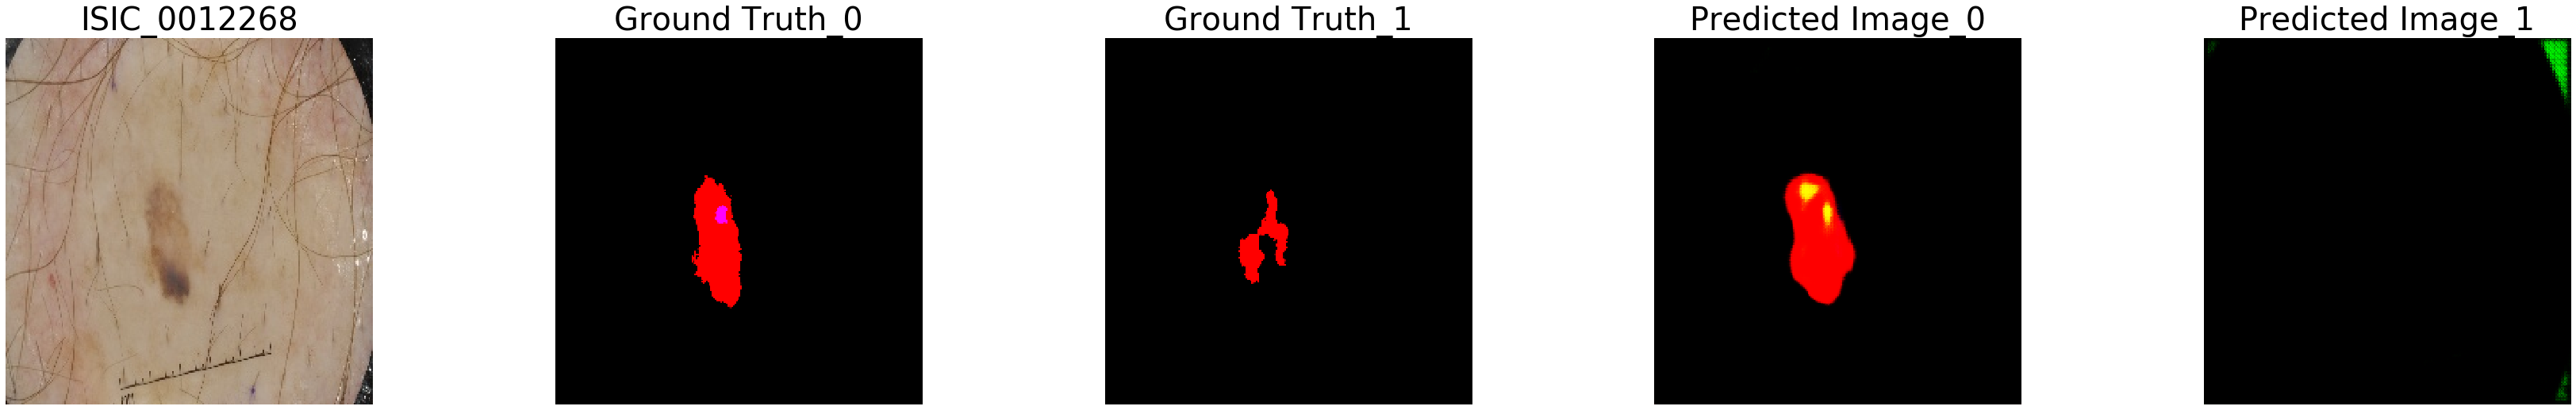

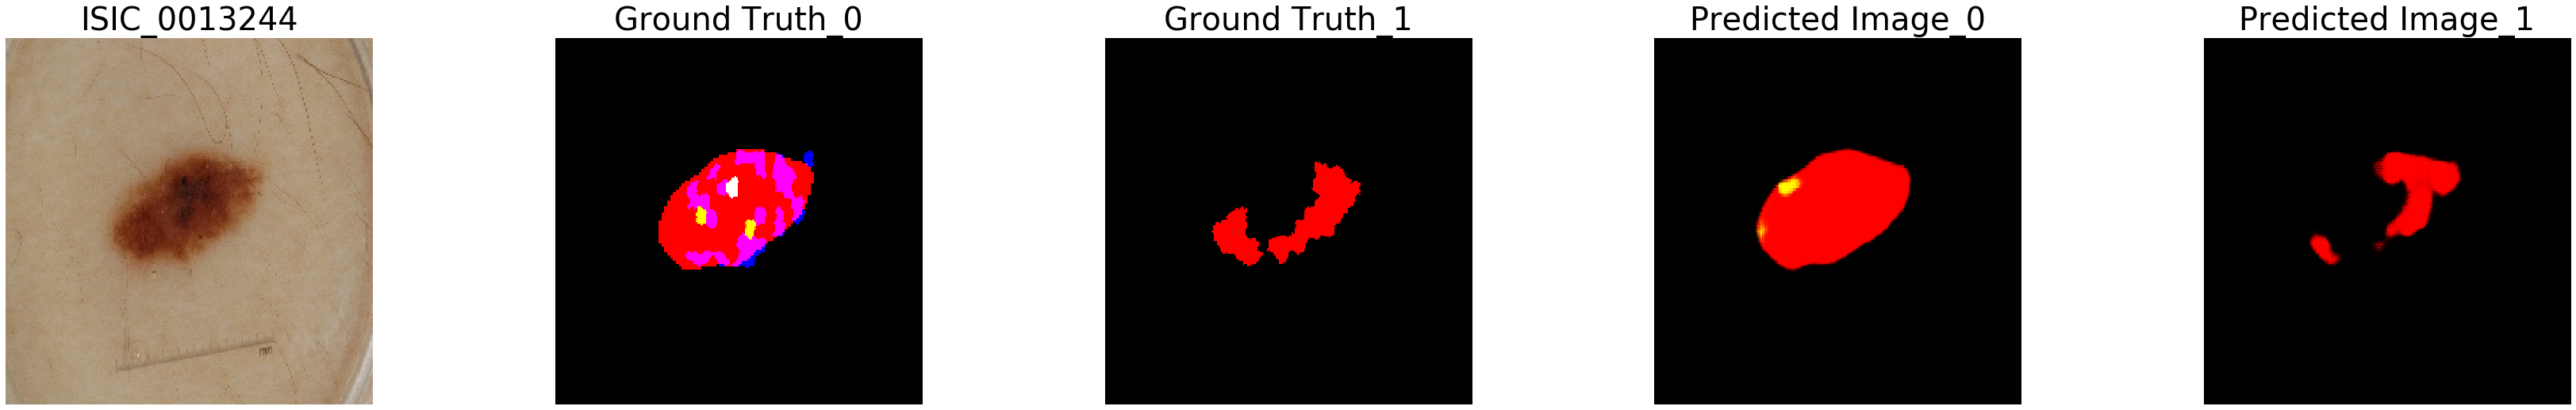

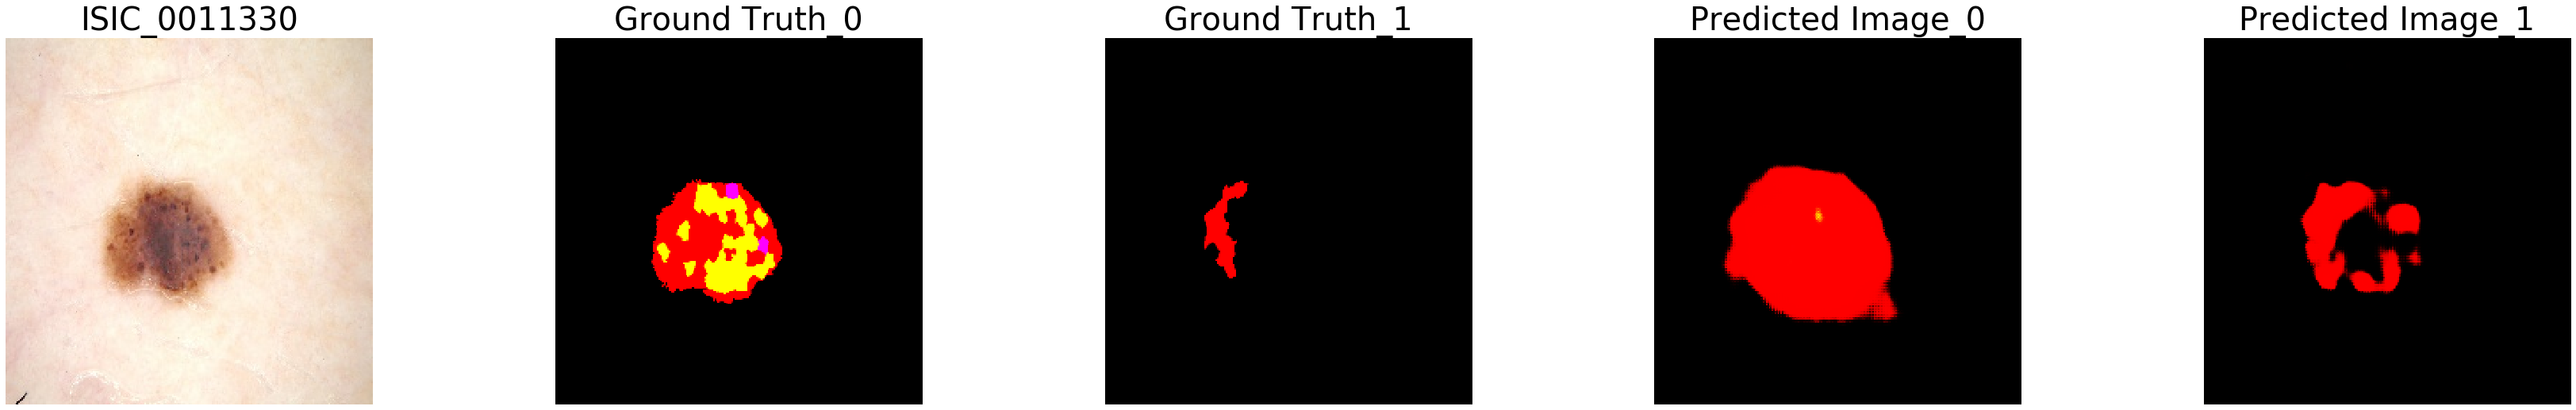

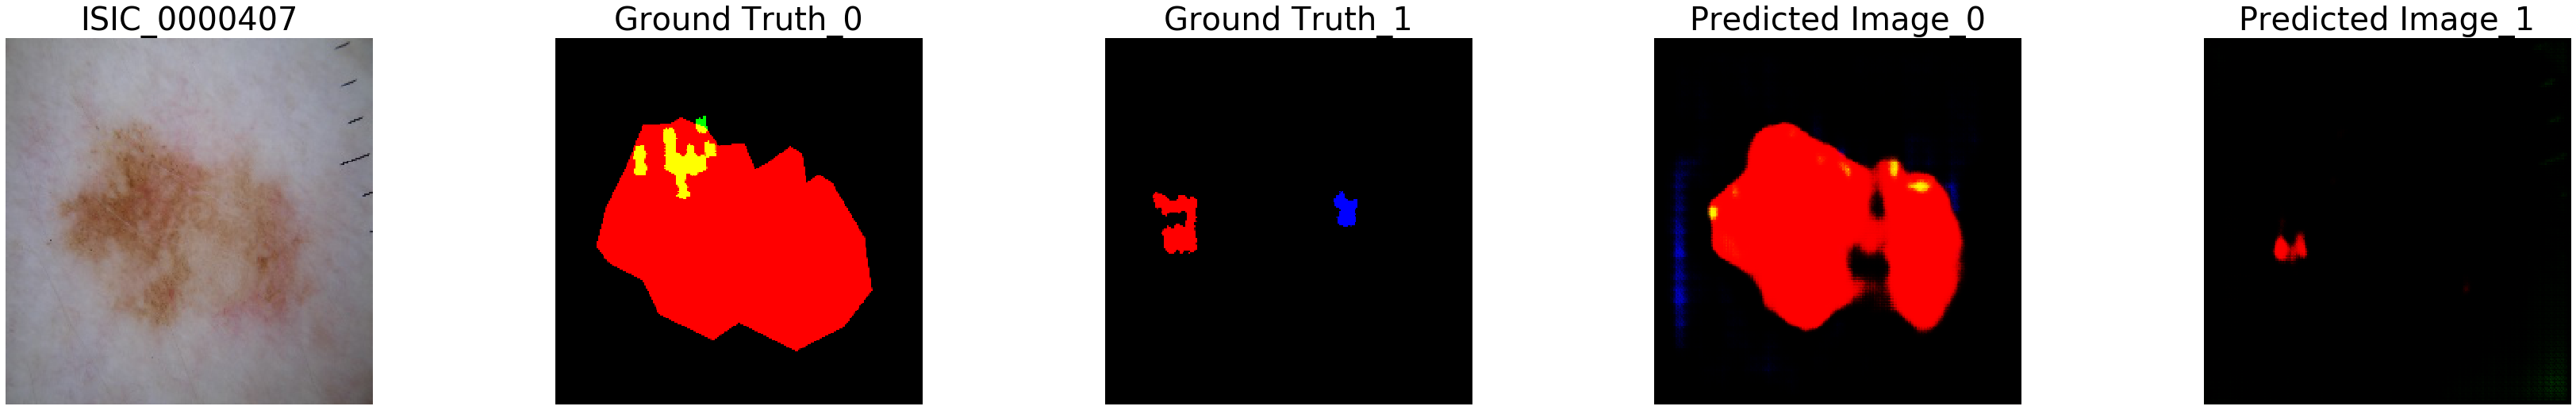

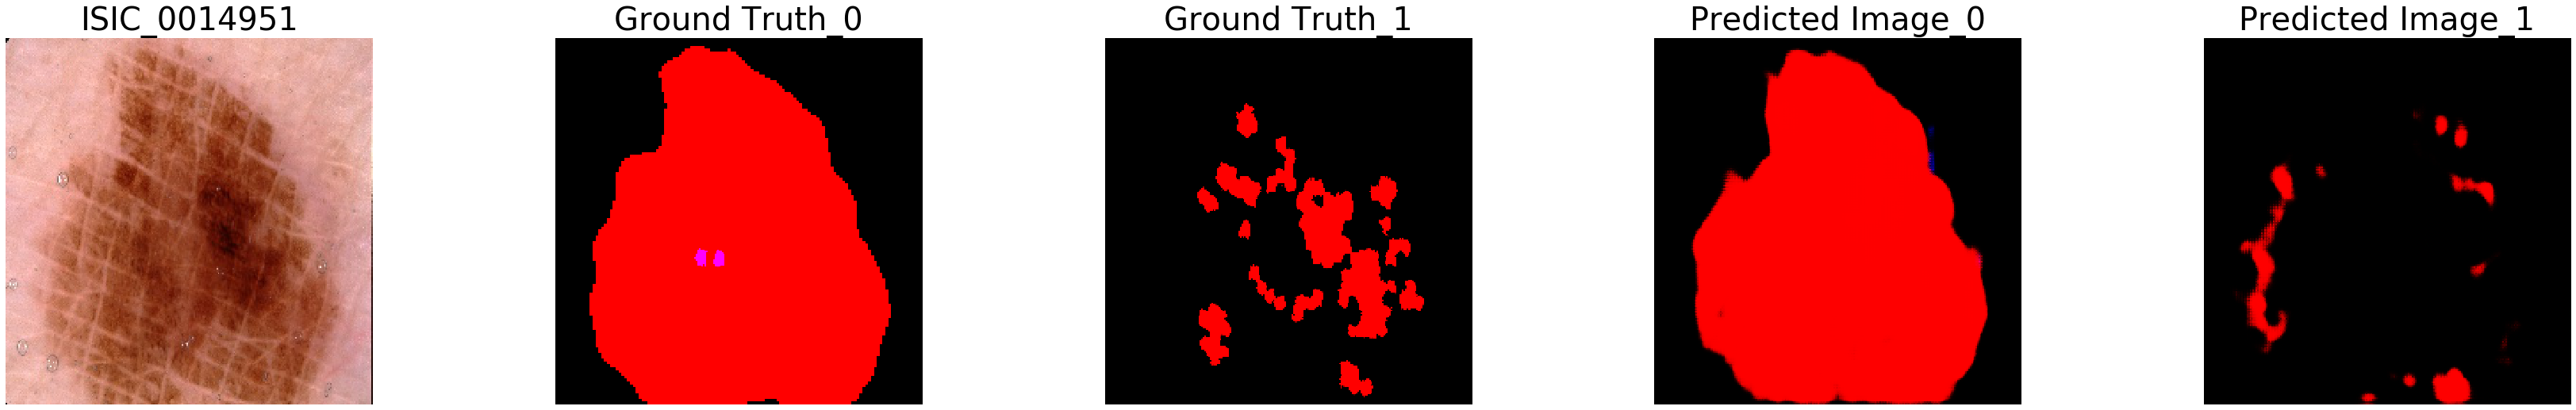

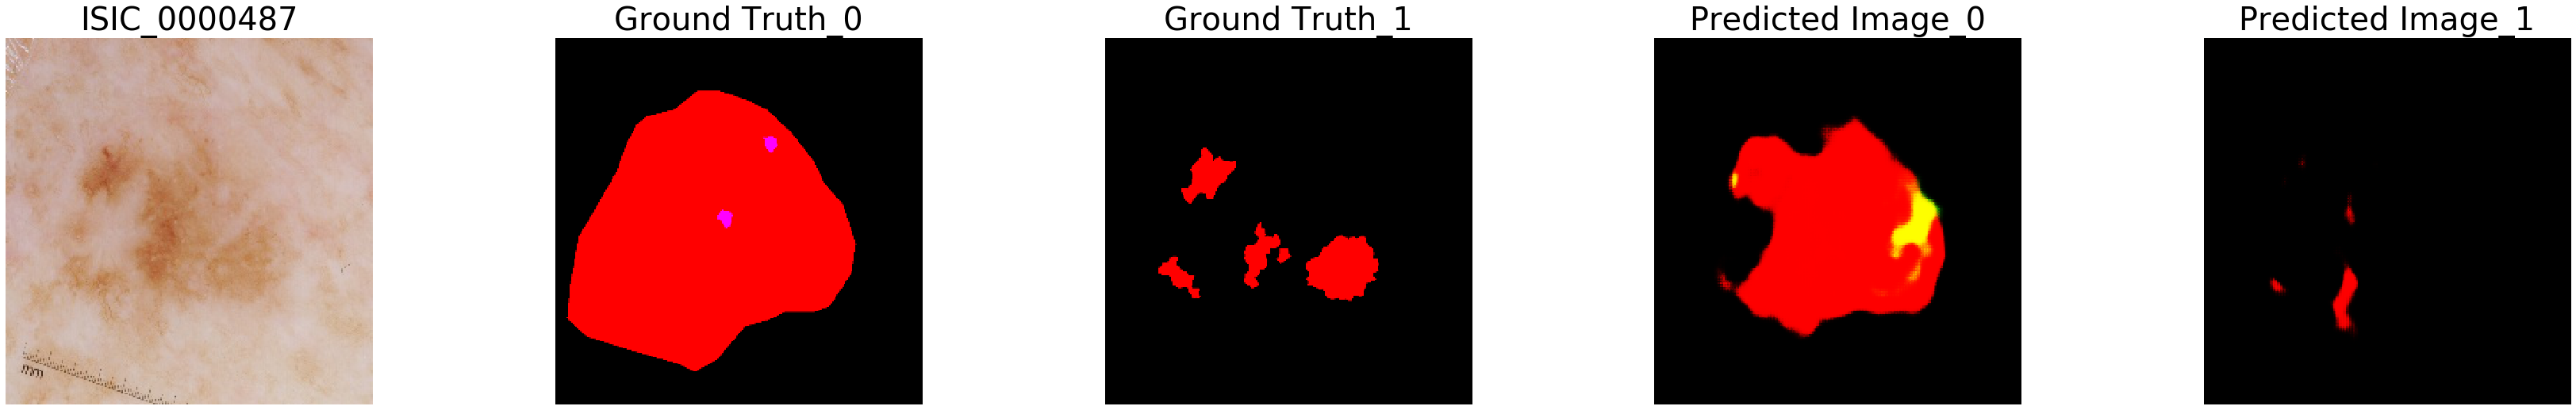

In [26]:
train(train_dataset,n_epochs)

In [27]:
plt.rcParams['figure.figsize'] = [60,8.5]


In [28]:
jaccard_index_total_aux = jaccard_index_total.copy()
np.save('jaccard_index_PATCHGAN'+str(CHANNELS_PATCHGAN)+'_'+str(BATCH_SIZE)+'_'+str(n)+'_XD.npy',jaccard_index_total_aux)

In [41]:
jaccard_index_total = np.load('jaccard_index_PATCHGAN'+str(CHANNELS_PATCHGAN)+'_'+str(BATCH_SIZE)+'_'+str(n)+'_XD.npy')

jaccard_atribute = []
for i in range(CHANNELS):
    jaccard_atribute.append([])
for jaccard_by_epoch in jaccard_index_total:
    for j in range(CHANNELS):
        jaccard_atribute[j].append(jaccard_by_epoch[j])

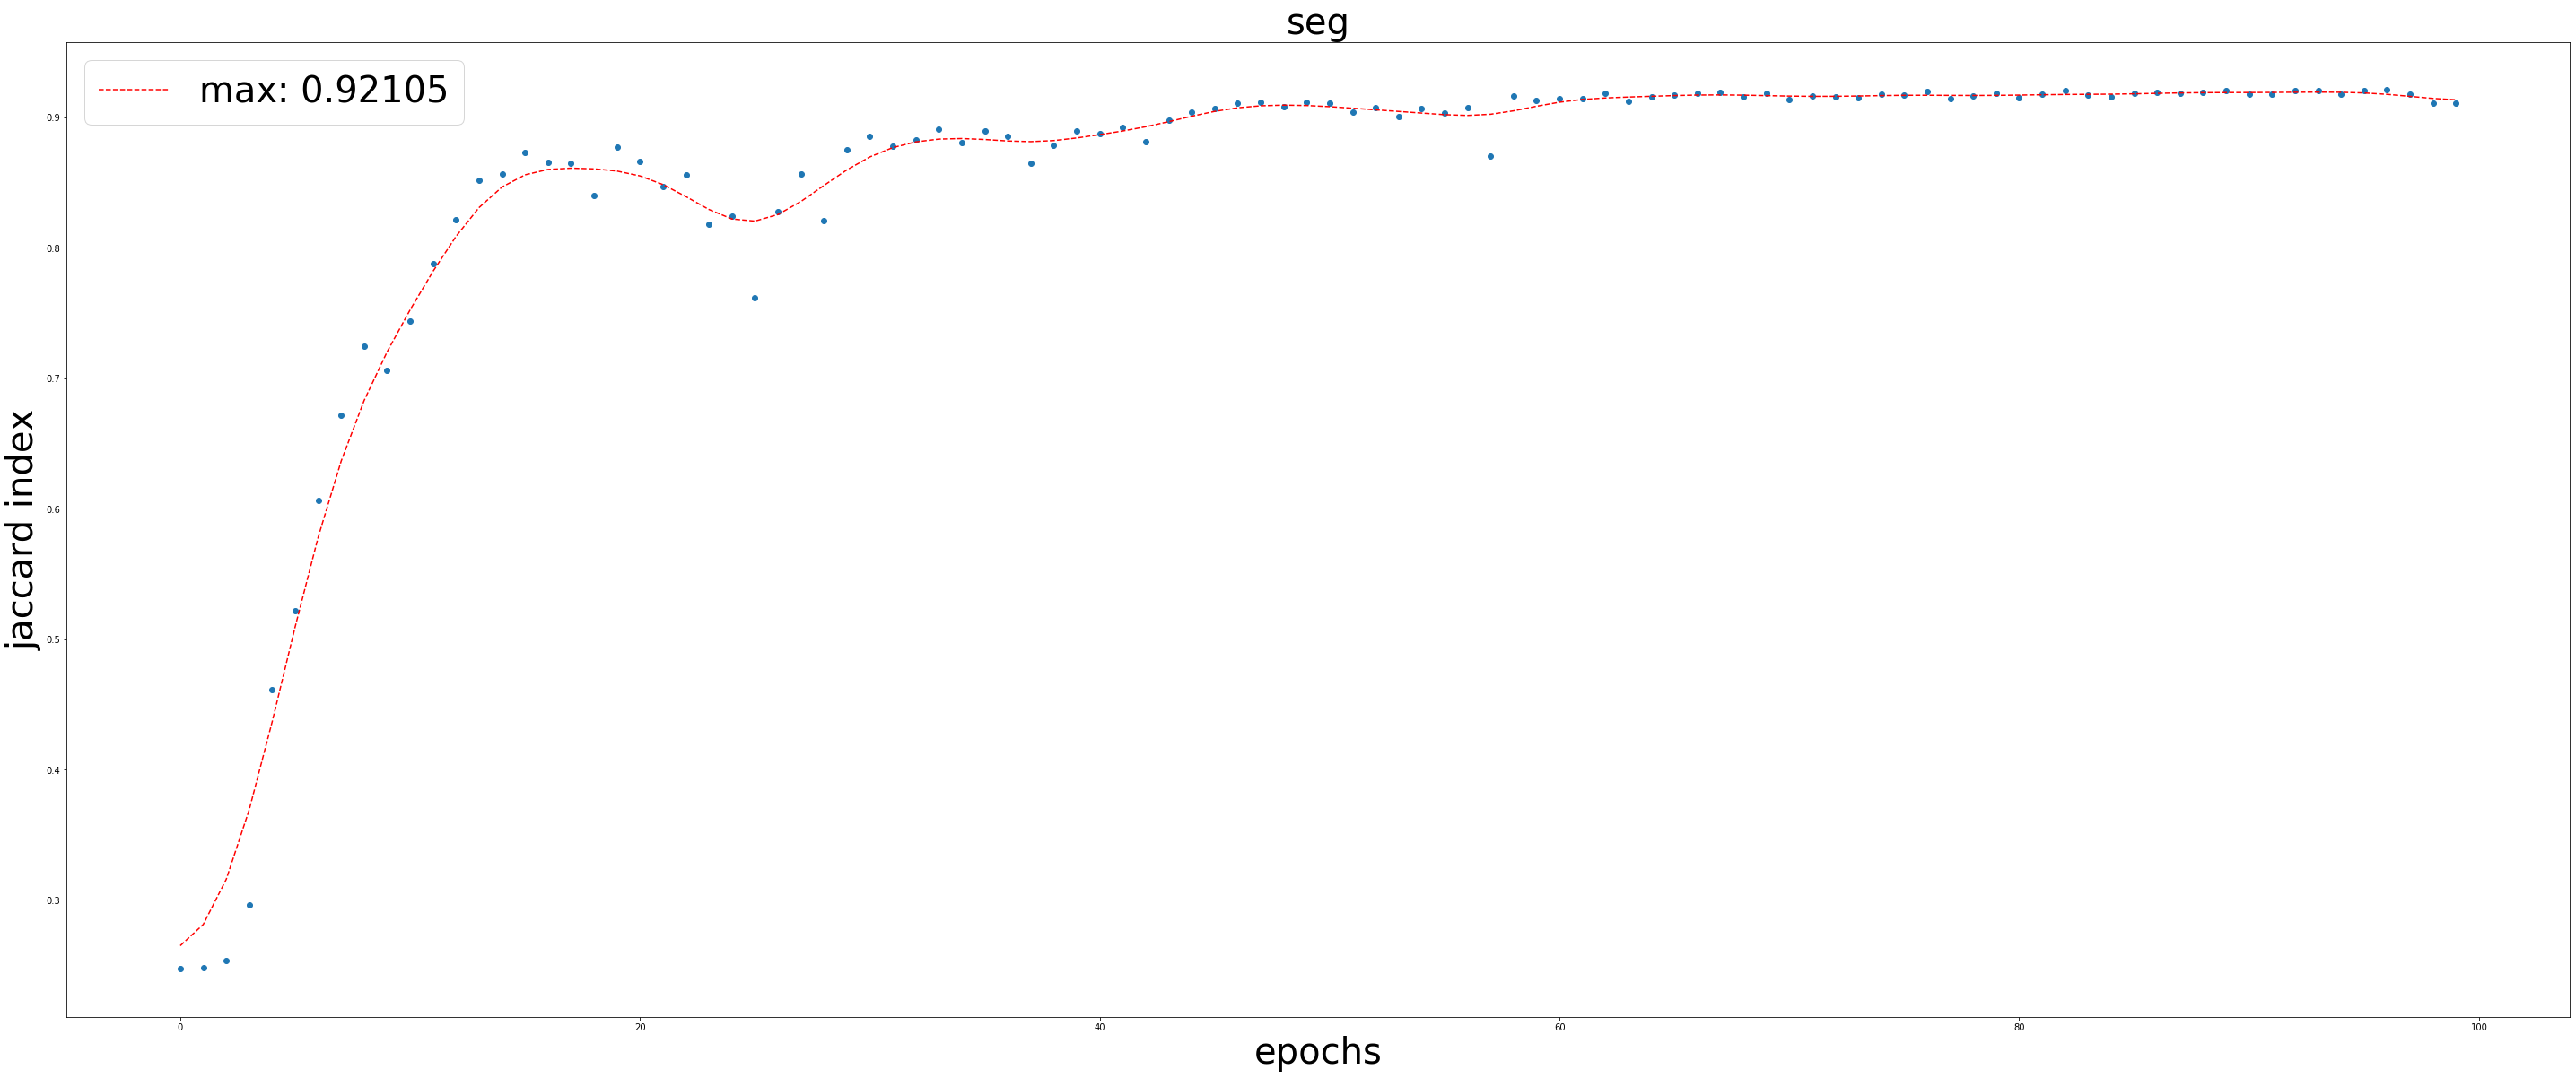

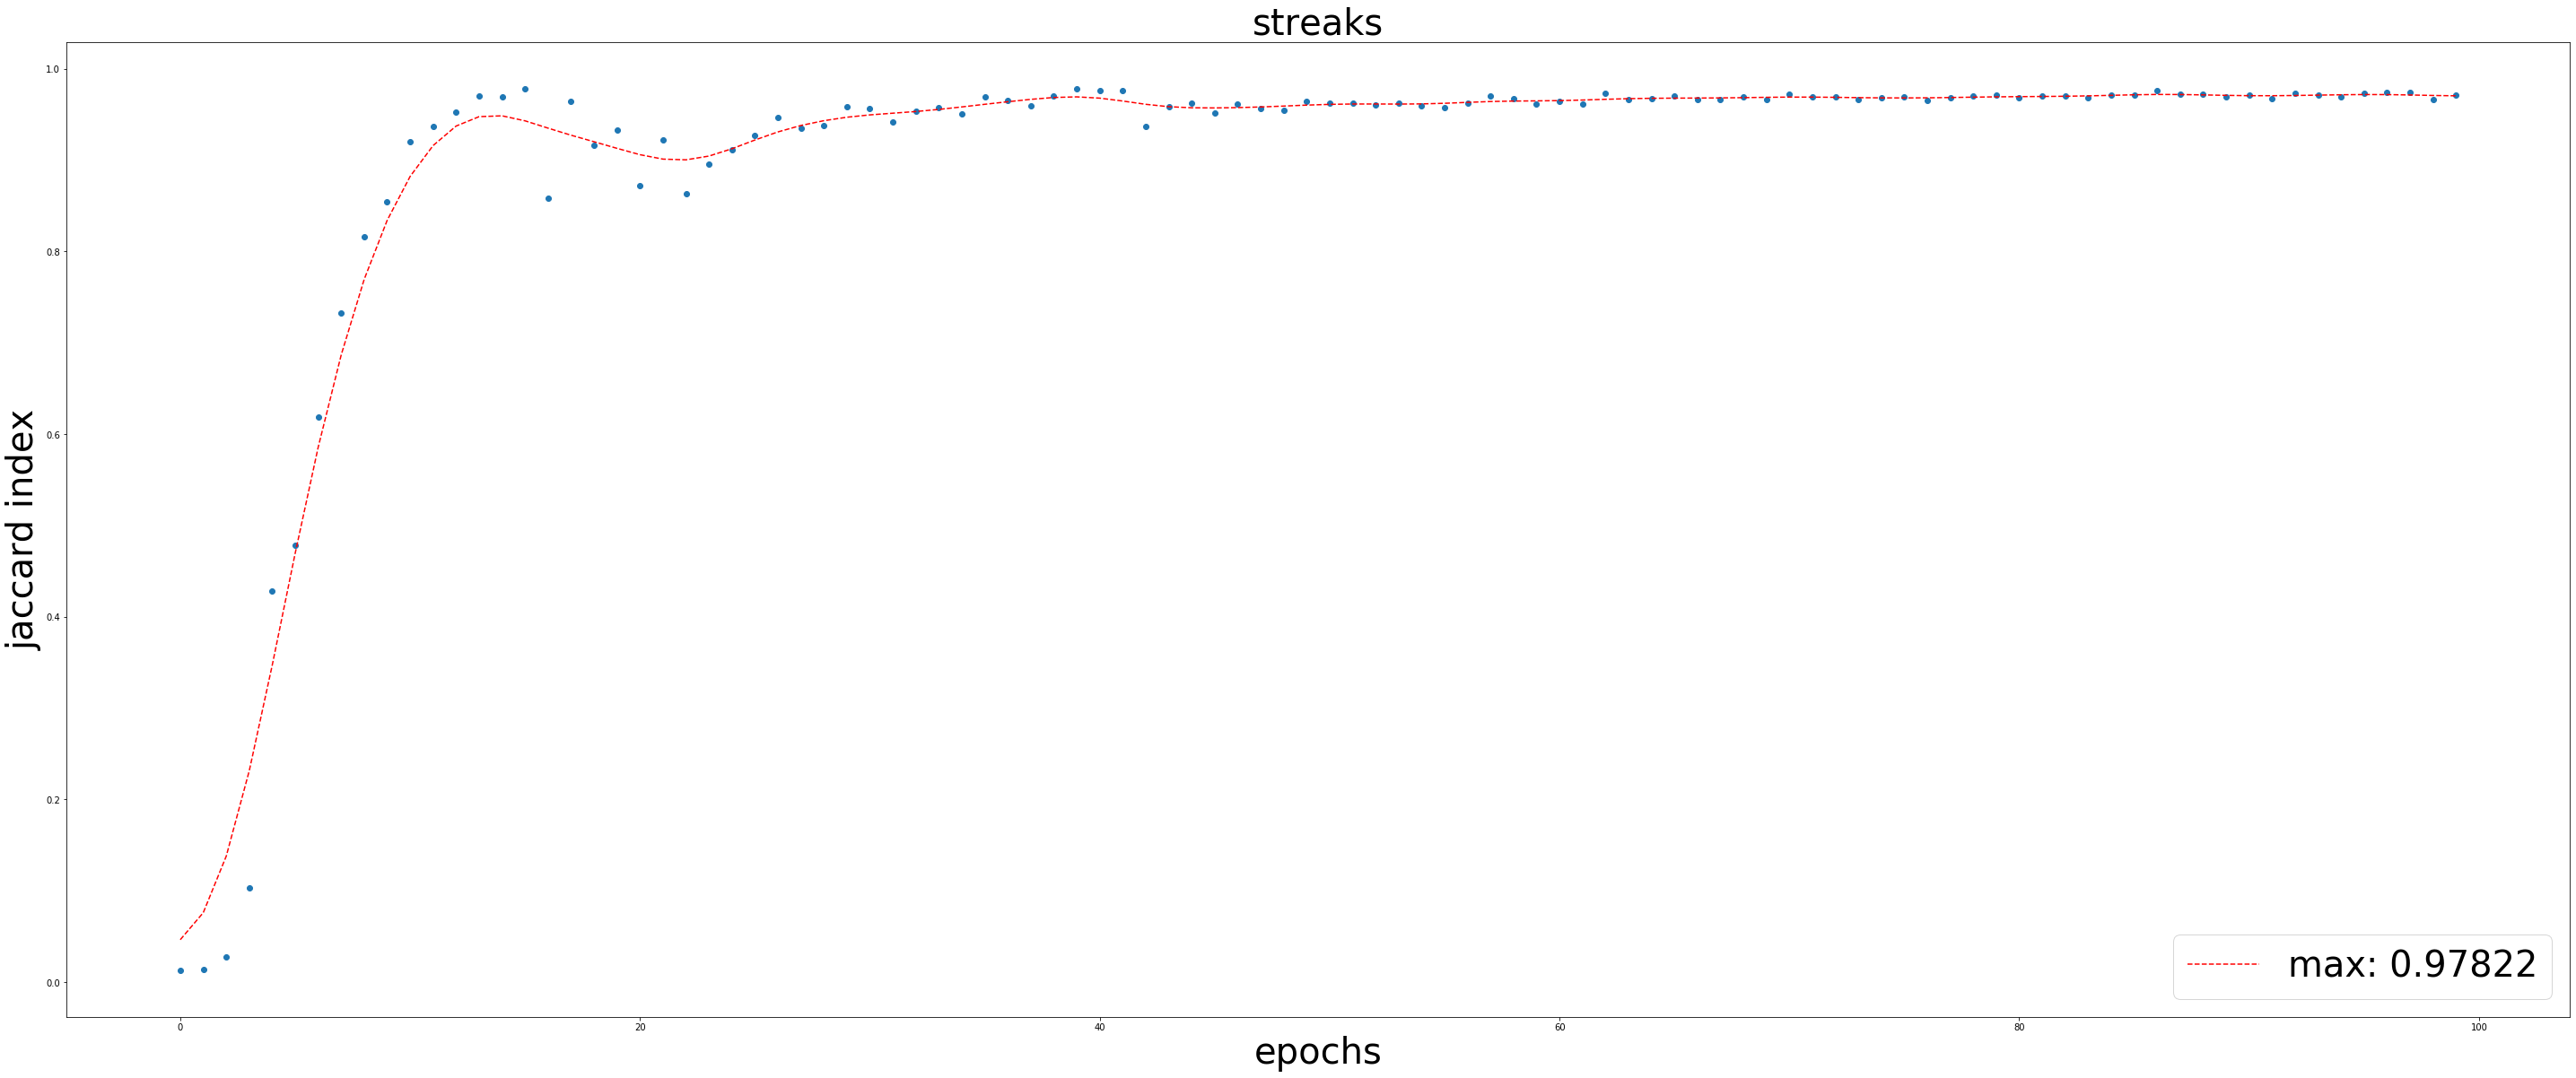

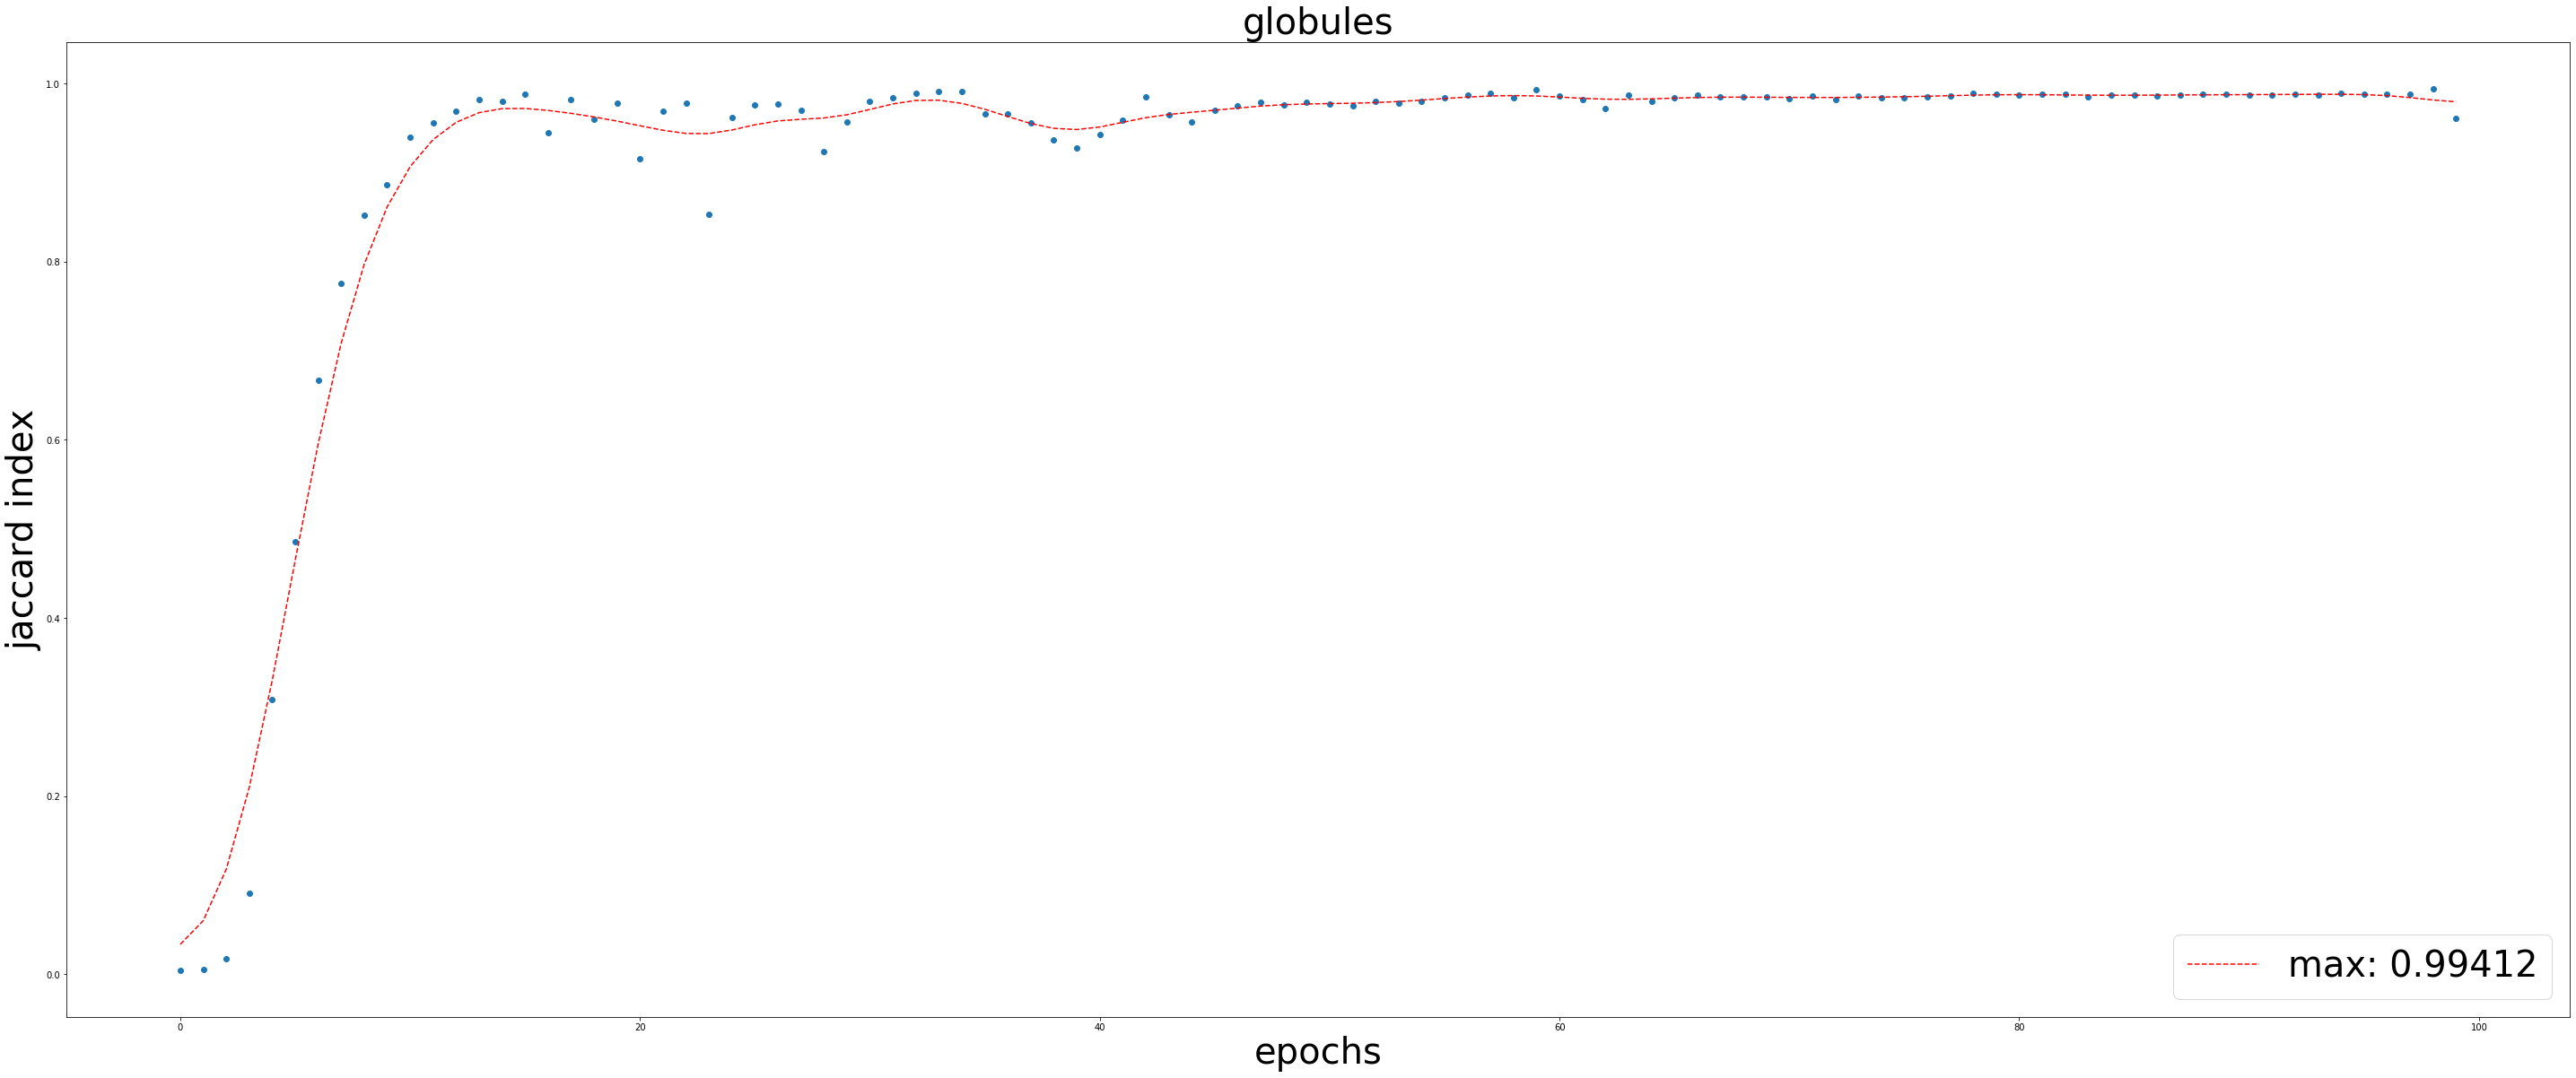

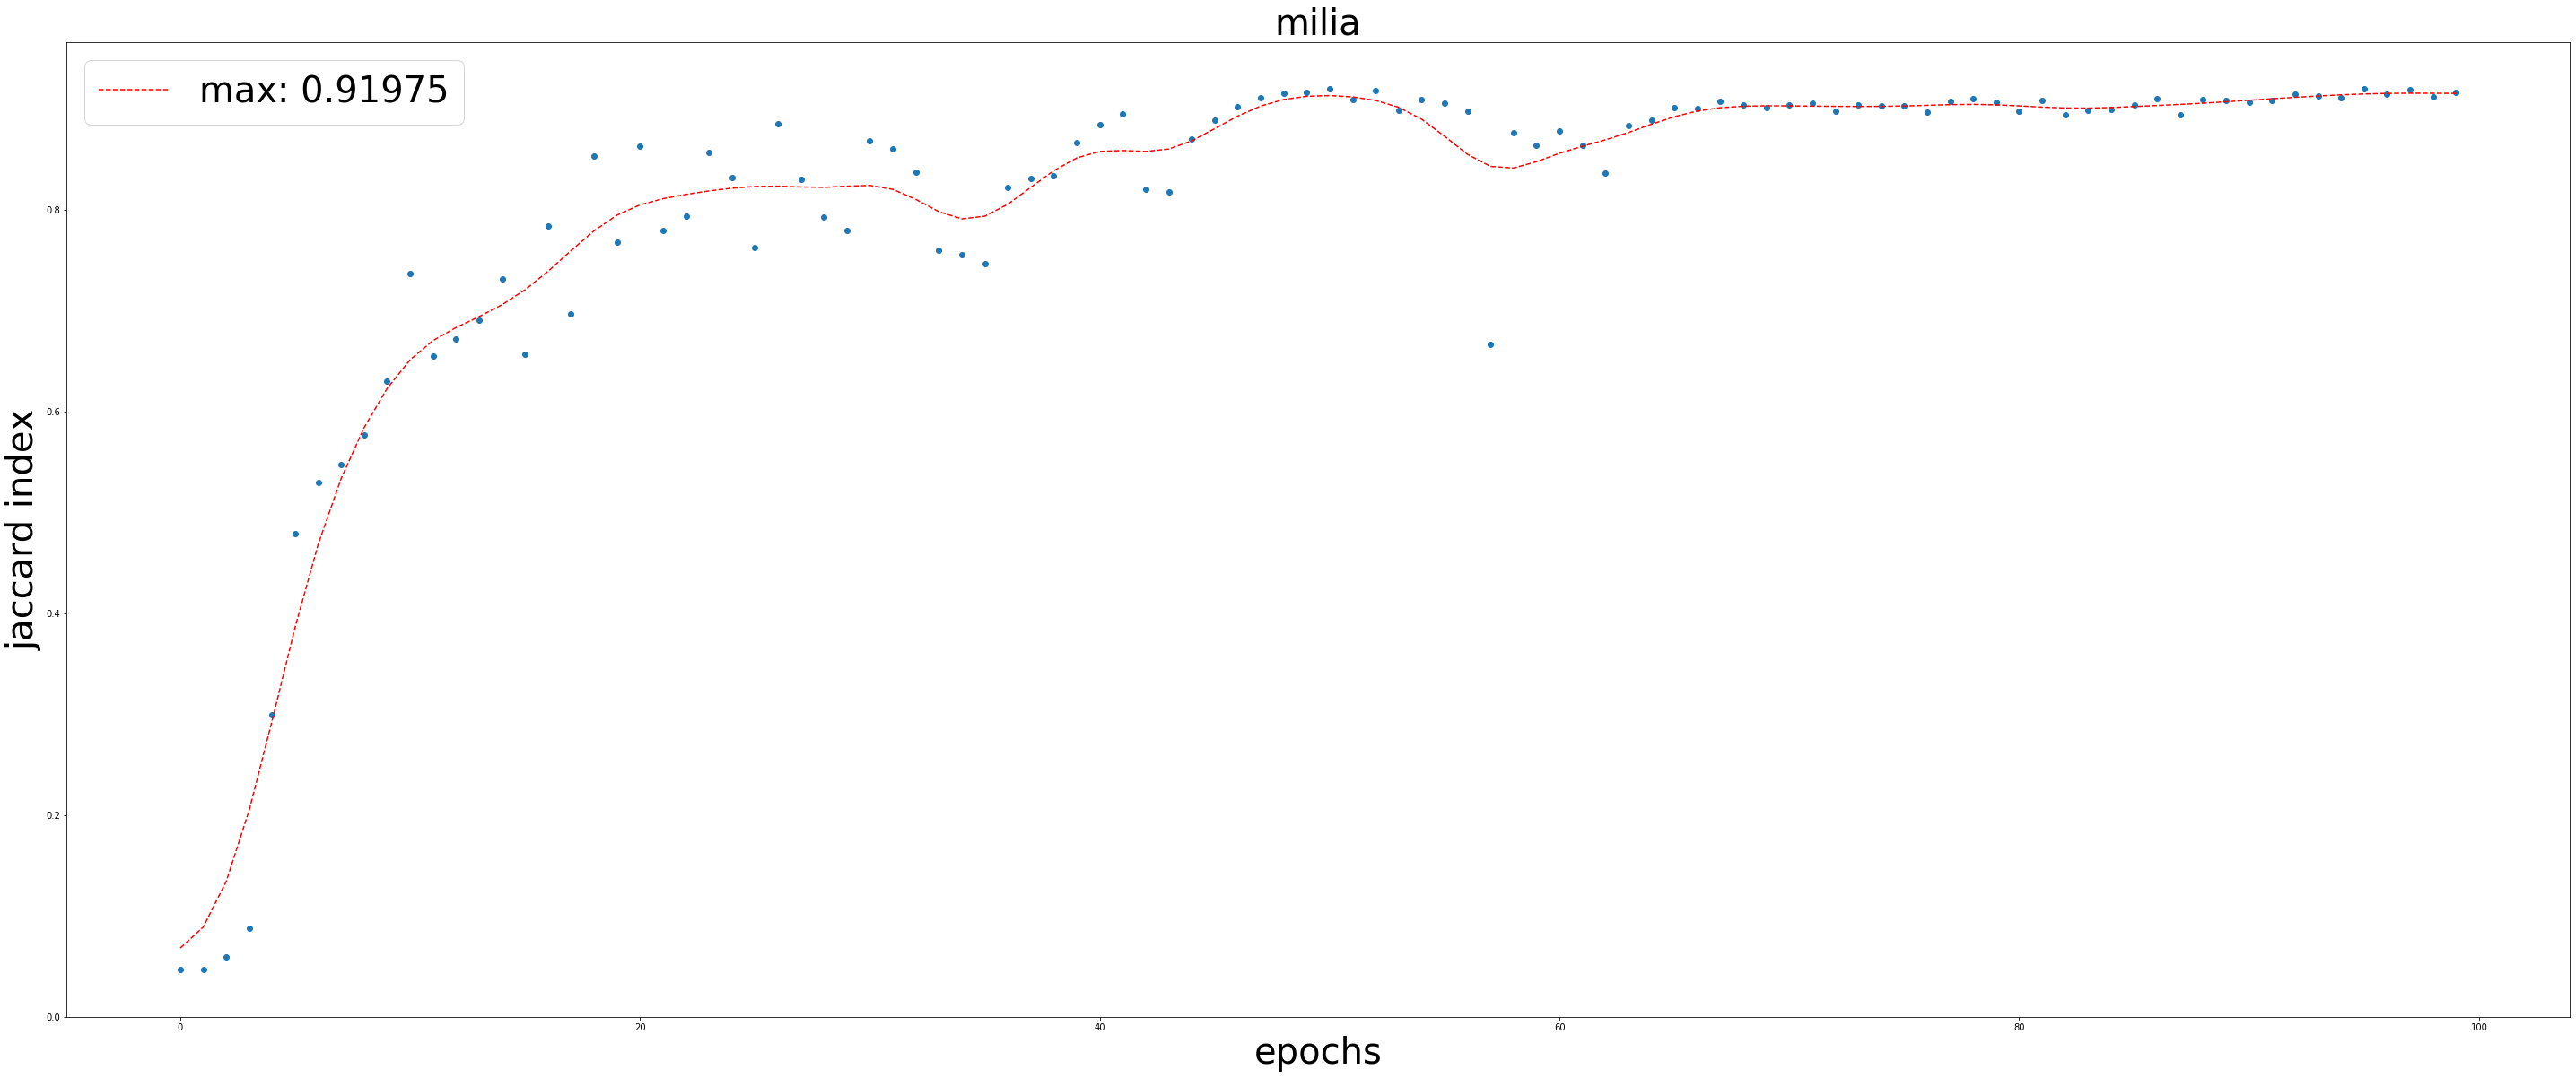

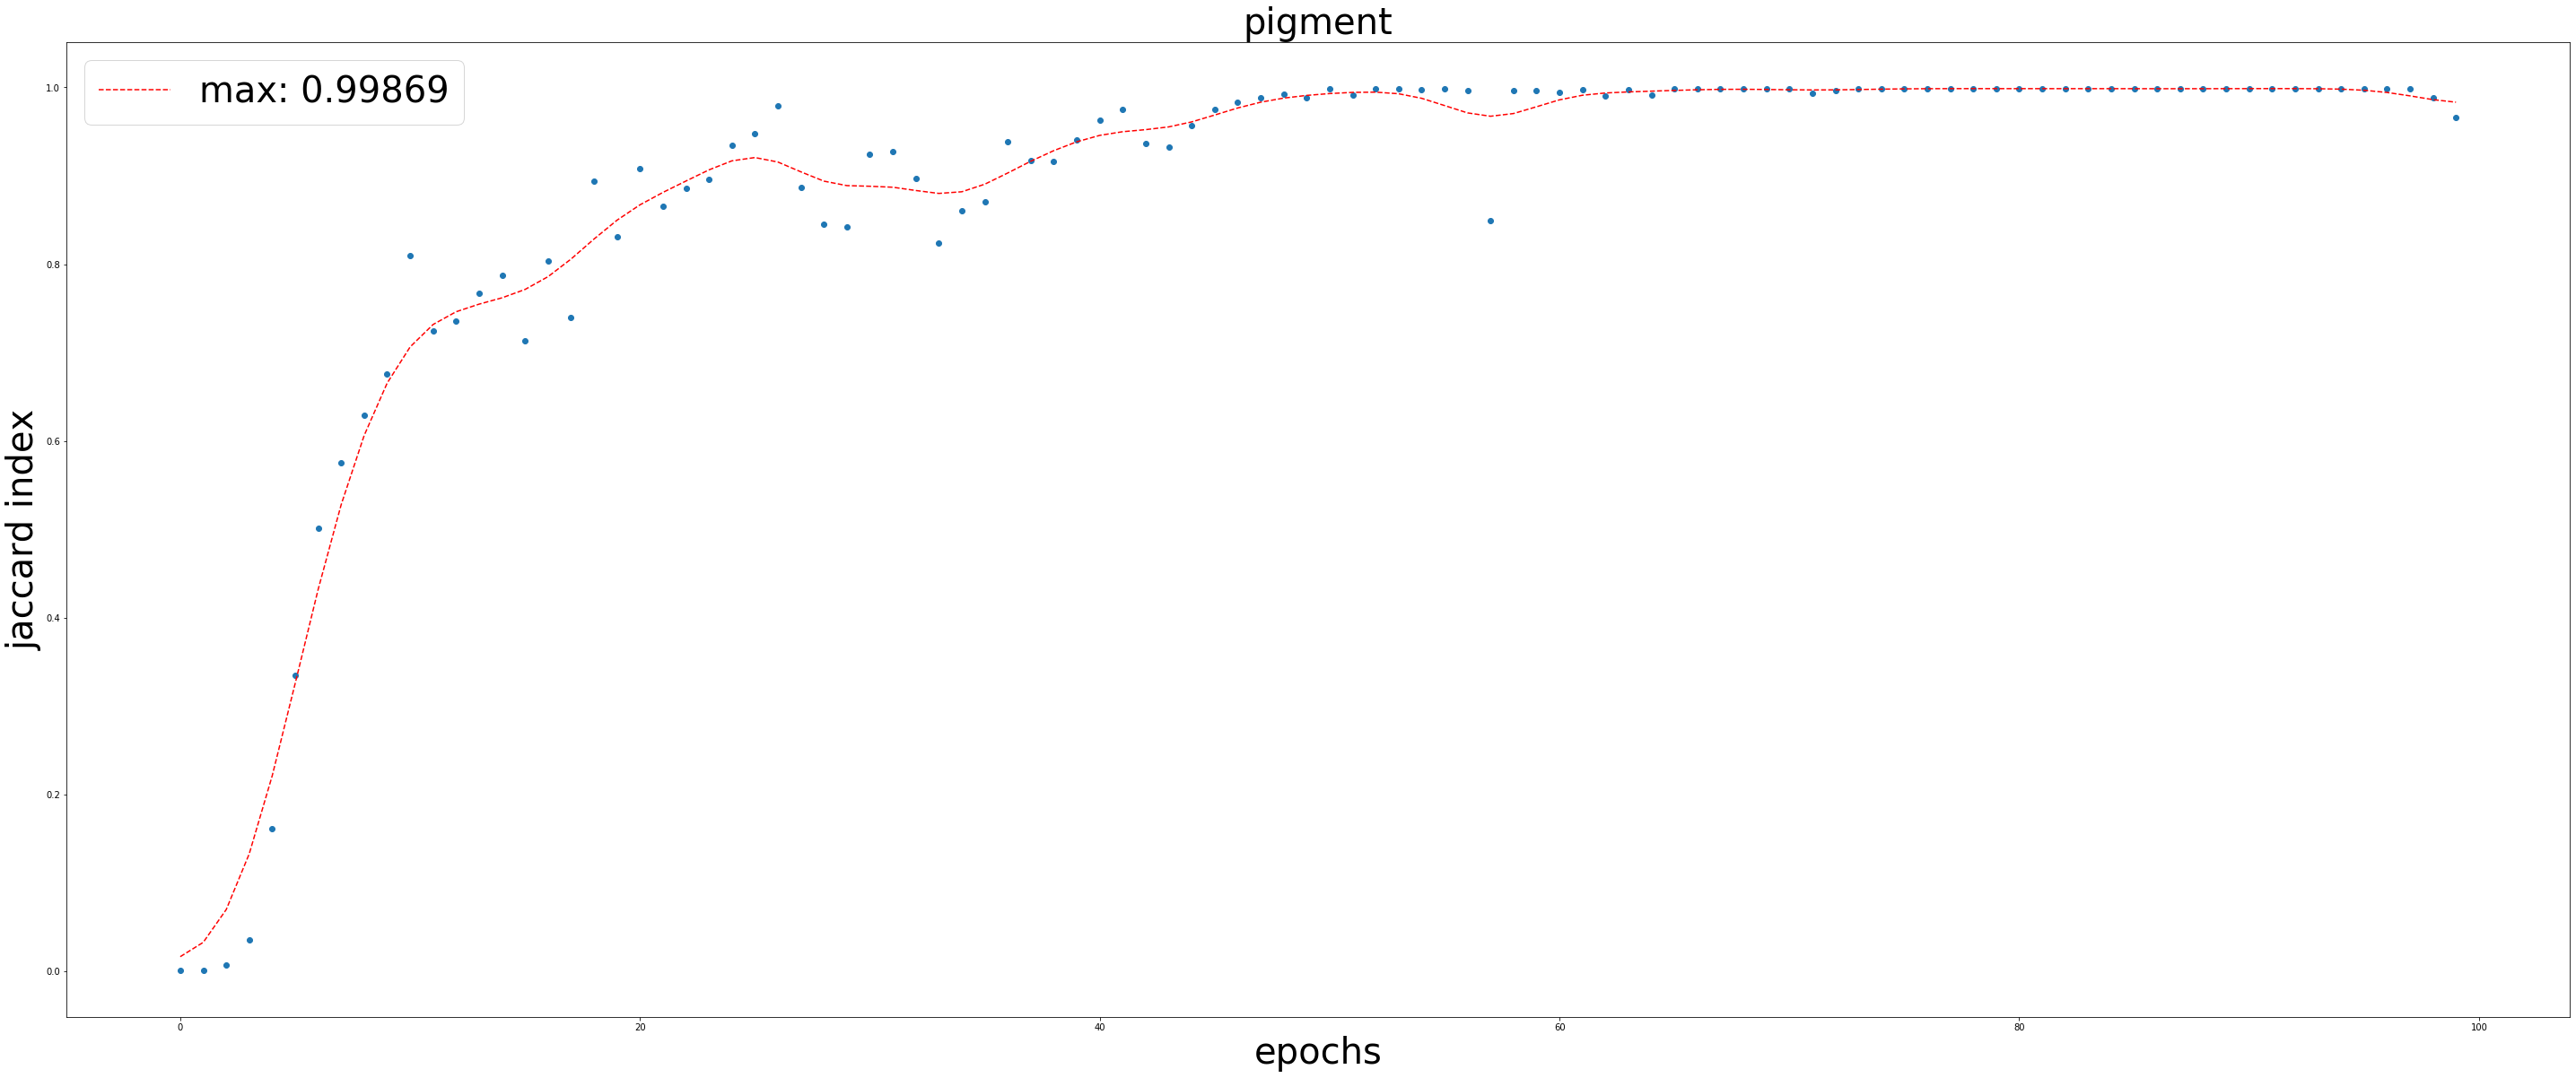

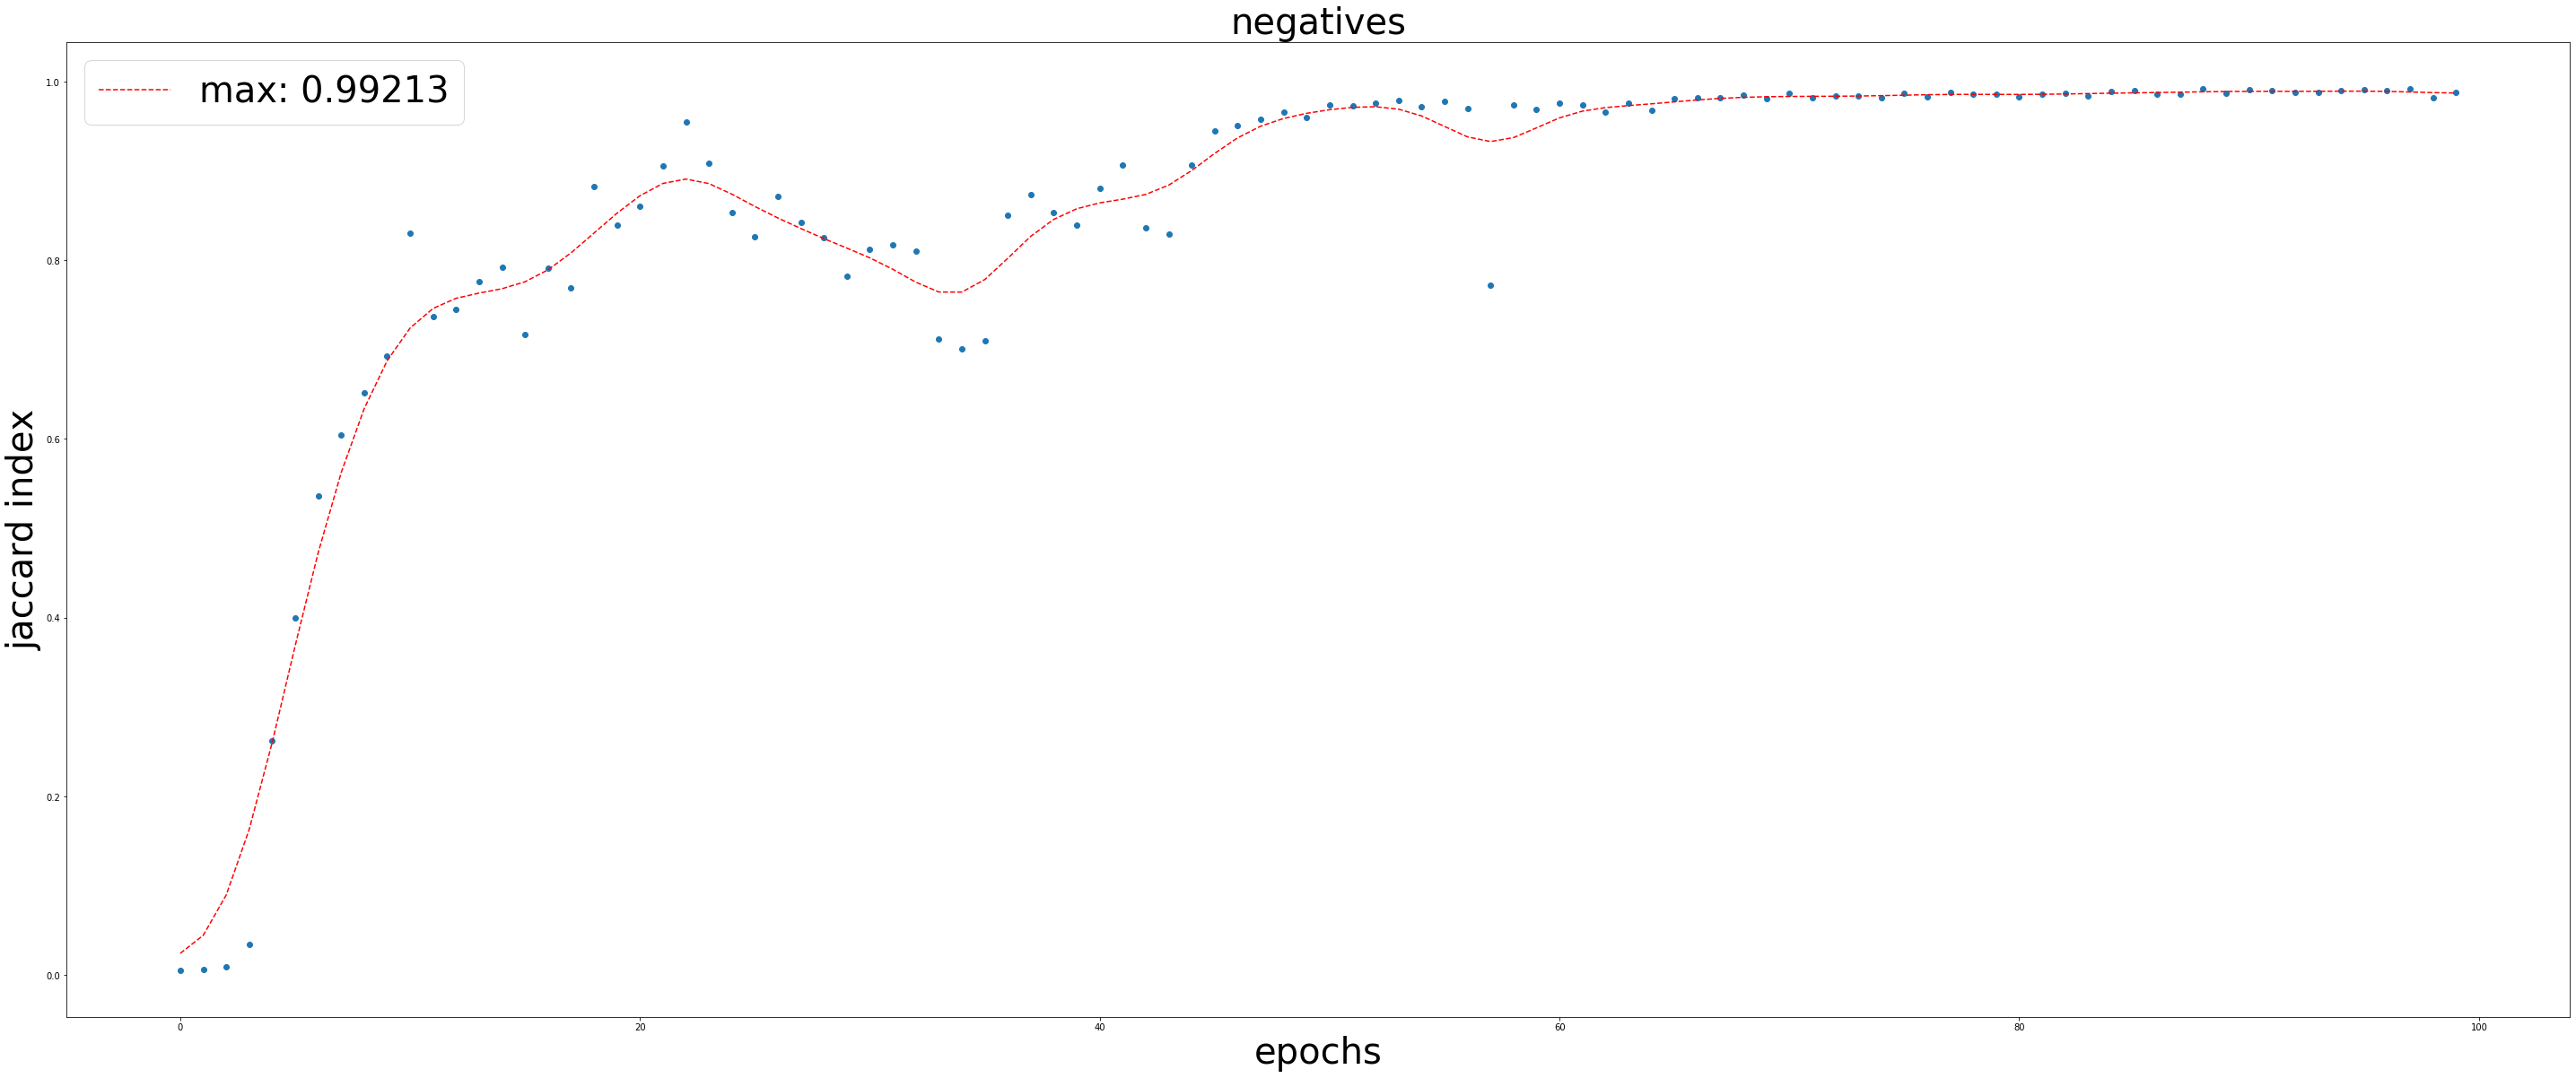

In [42]:
for idx,jaccard_idx in enumerate(jaccard_atribute):
    fig = plt.figure(figsize=(50,20))
    n_epochs = 100
    jaccard_idx = jaccard_idx[0:100]
    plt.scatter(range(0,n_epochs),jaccard_idx)
    #z = np.polyfit(range(0,n_epochs), np.log(jaccard_idx),1)
    #p = np.poly1d(z)
    #plt.plot(range(0,n_epochs),np.exp(p(range(0,n_epochs))),"r--")
    
    from scipy.ndimage.filters import gaussian_filter1d
    ysmoothed = gaussian_filter1d(jaccard_idx, sigma=2)
    plt.plot(range(0,n_epochs),ysmoothed,"r--")

    
    #fig.suptitle(targets[idx], fontsize=20)
    plt.xlabel('epochs', fontsize=40)
    plt.ylabel('jaccard index', fontsize=40)
    maxi = str(round(np.max(jaccard_idx),5))
    plt.legend(['max: '+maxi],fontsize=40)
    plt.title(targets[idx], fontsize=40)
    plt.show()
    fig.savefig(REPATH+TARGET+'_jaccard_'+targets[idx]+'.jpg')

In [43]:
jaccard_index_total = np.load('jaccard_index_PATCHGAN'+str(1)+'_'+str(BATCH_SIZE)+'_'+str(n)+'_XD.npy')

jaccard_atribute_1 = []
for i in range(CHANNELS):
    jaccard_atribute_1.append([])
for jaccard_by_epoch in jaccard_index_total:
    for j in range(CHANNELS):
        jaccard_atribute_1[j].append(jaccard_by_epoch[j])
jaccard_index_total = np.load('jaccard_index_PATCHGAN'+str(6)+'_'+str(BATCH_SIZE)+'_'+str(n)+'_XD.npy')

jaccard_atribute_2 = []
for i in range(CHANNELS):
    jaccard_atribute_2.append([])
for jaccard_by_epoch in jaccard_index_total:
    for j in range(CHANNELS):
        jaccard_atribute_2[j].append(jaccard_by_epoch[j])
        

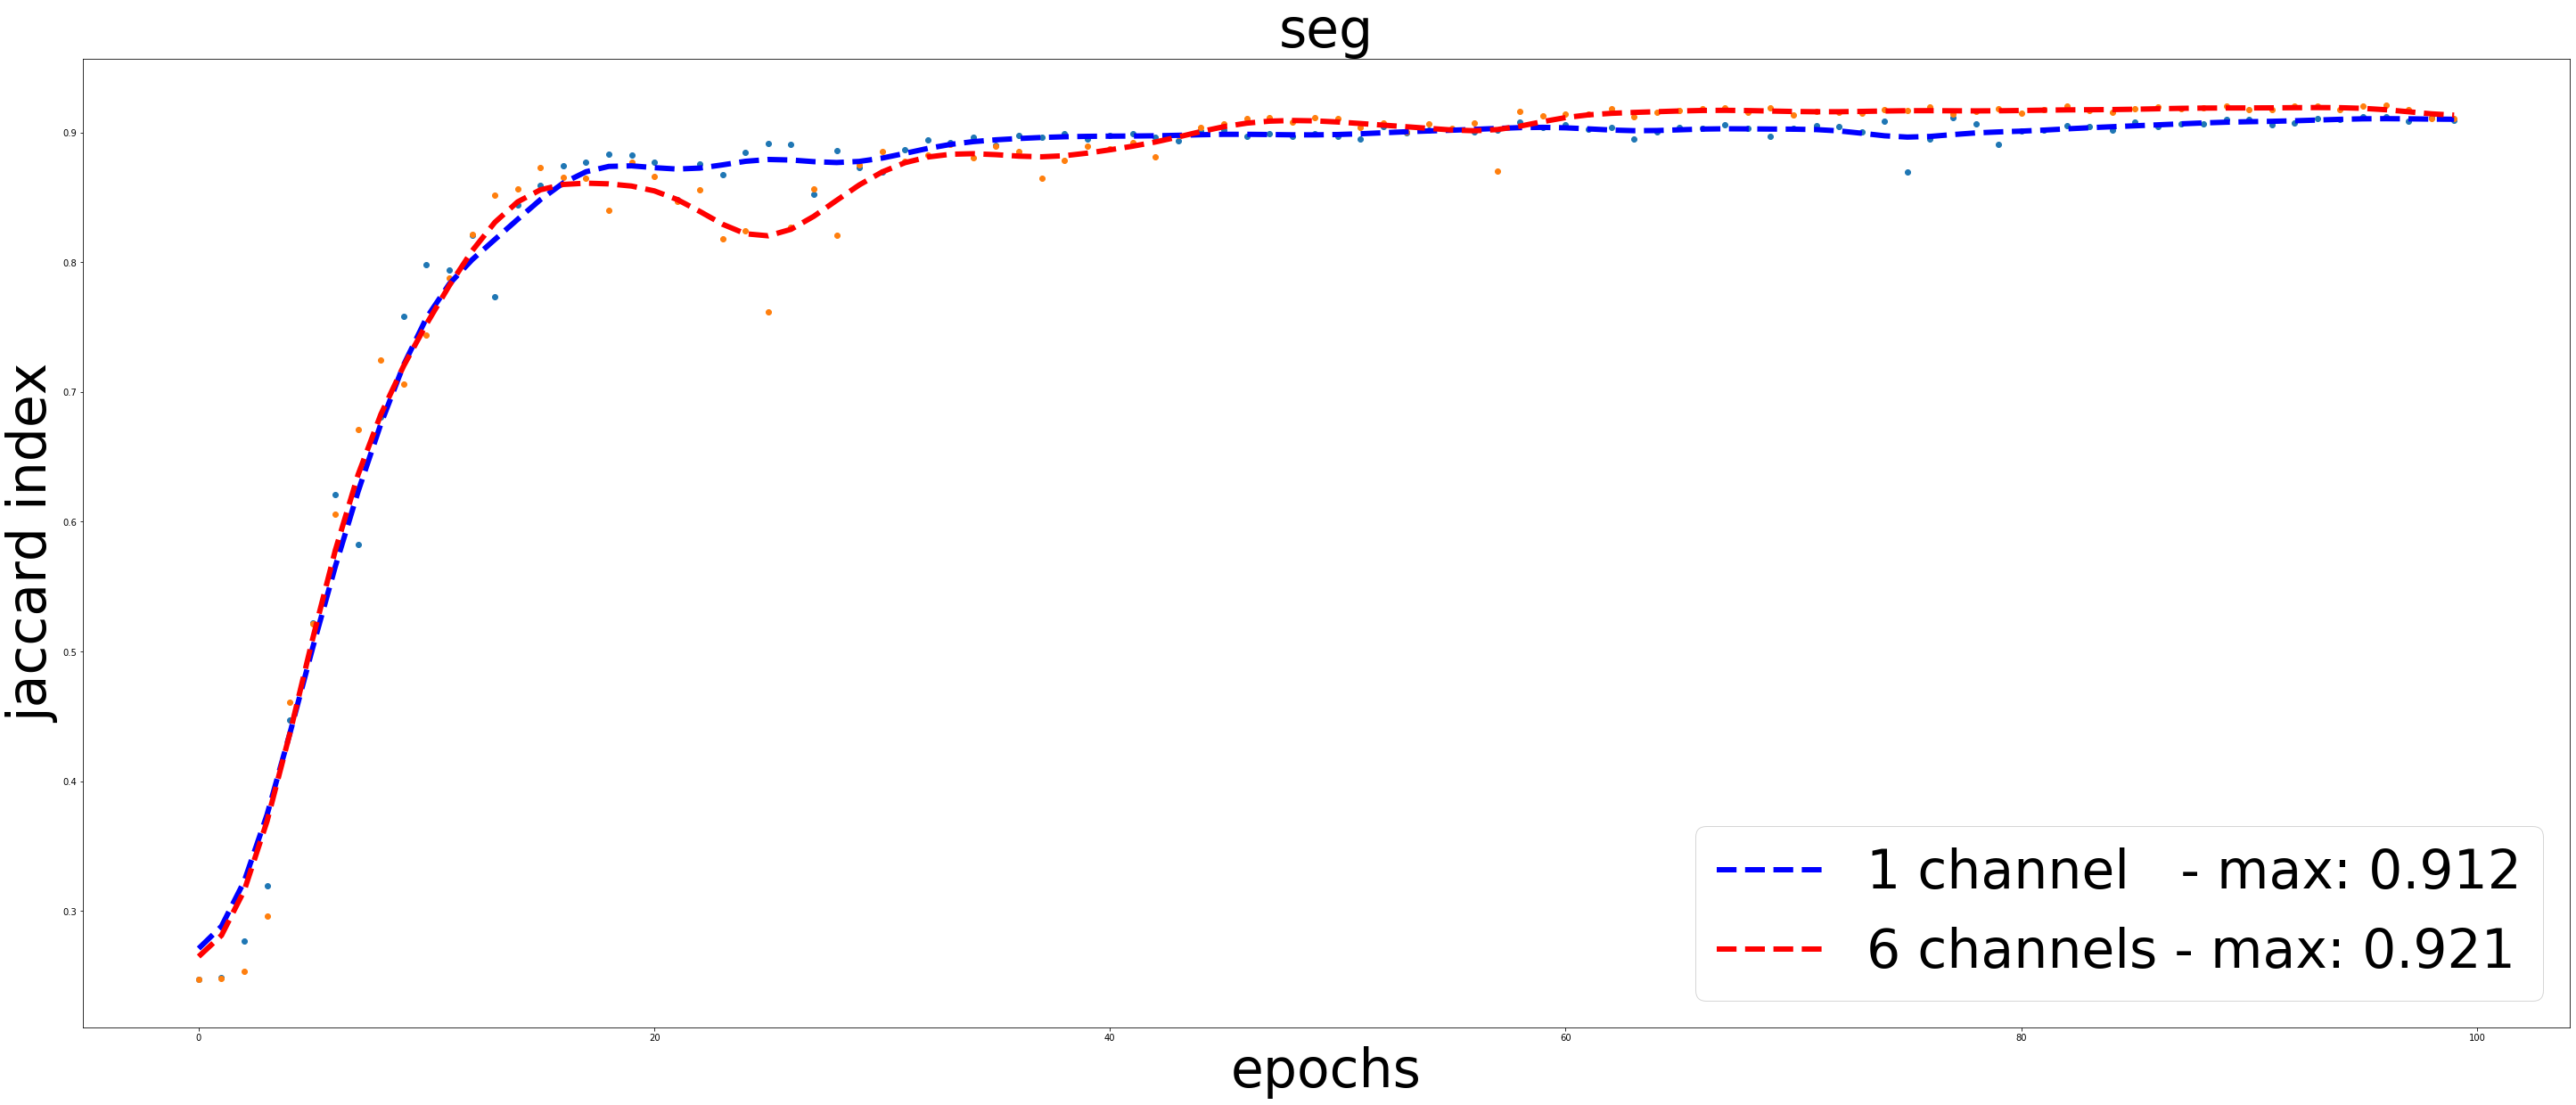

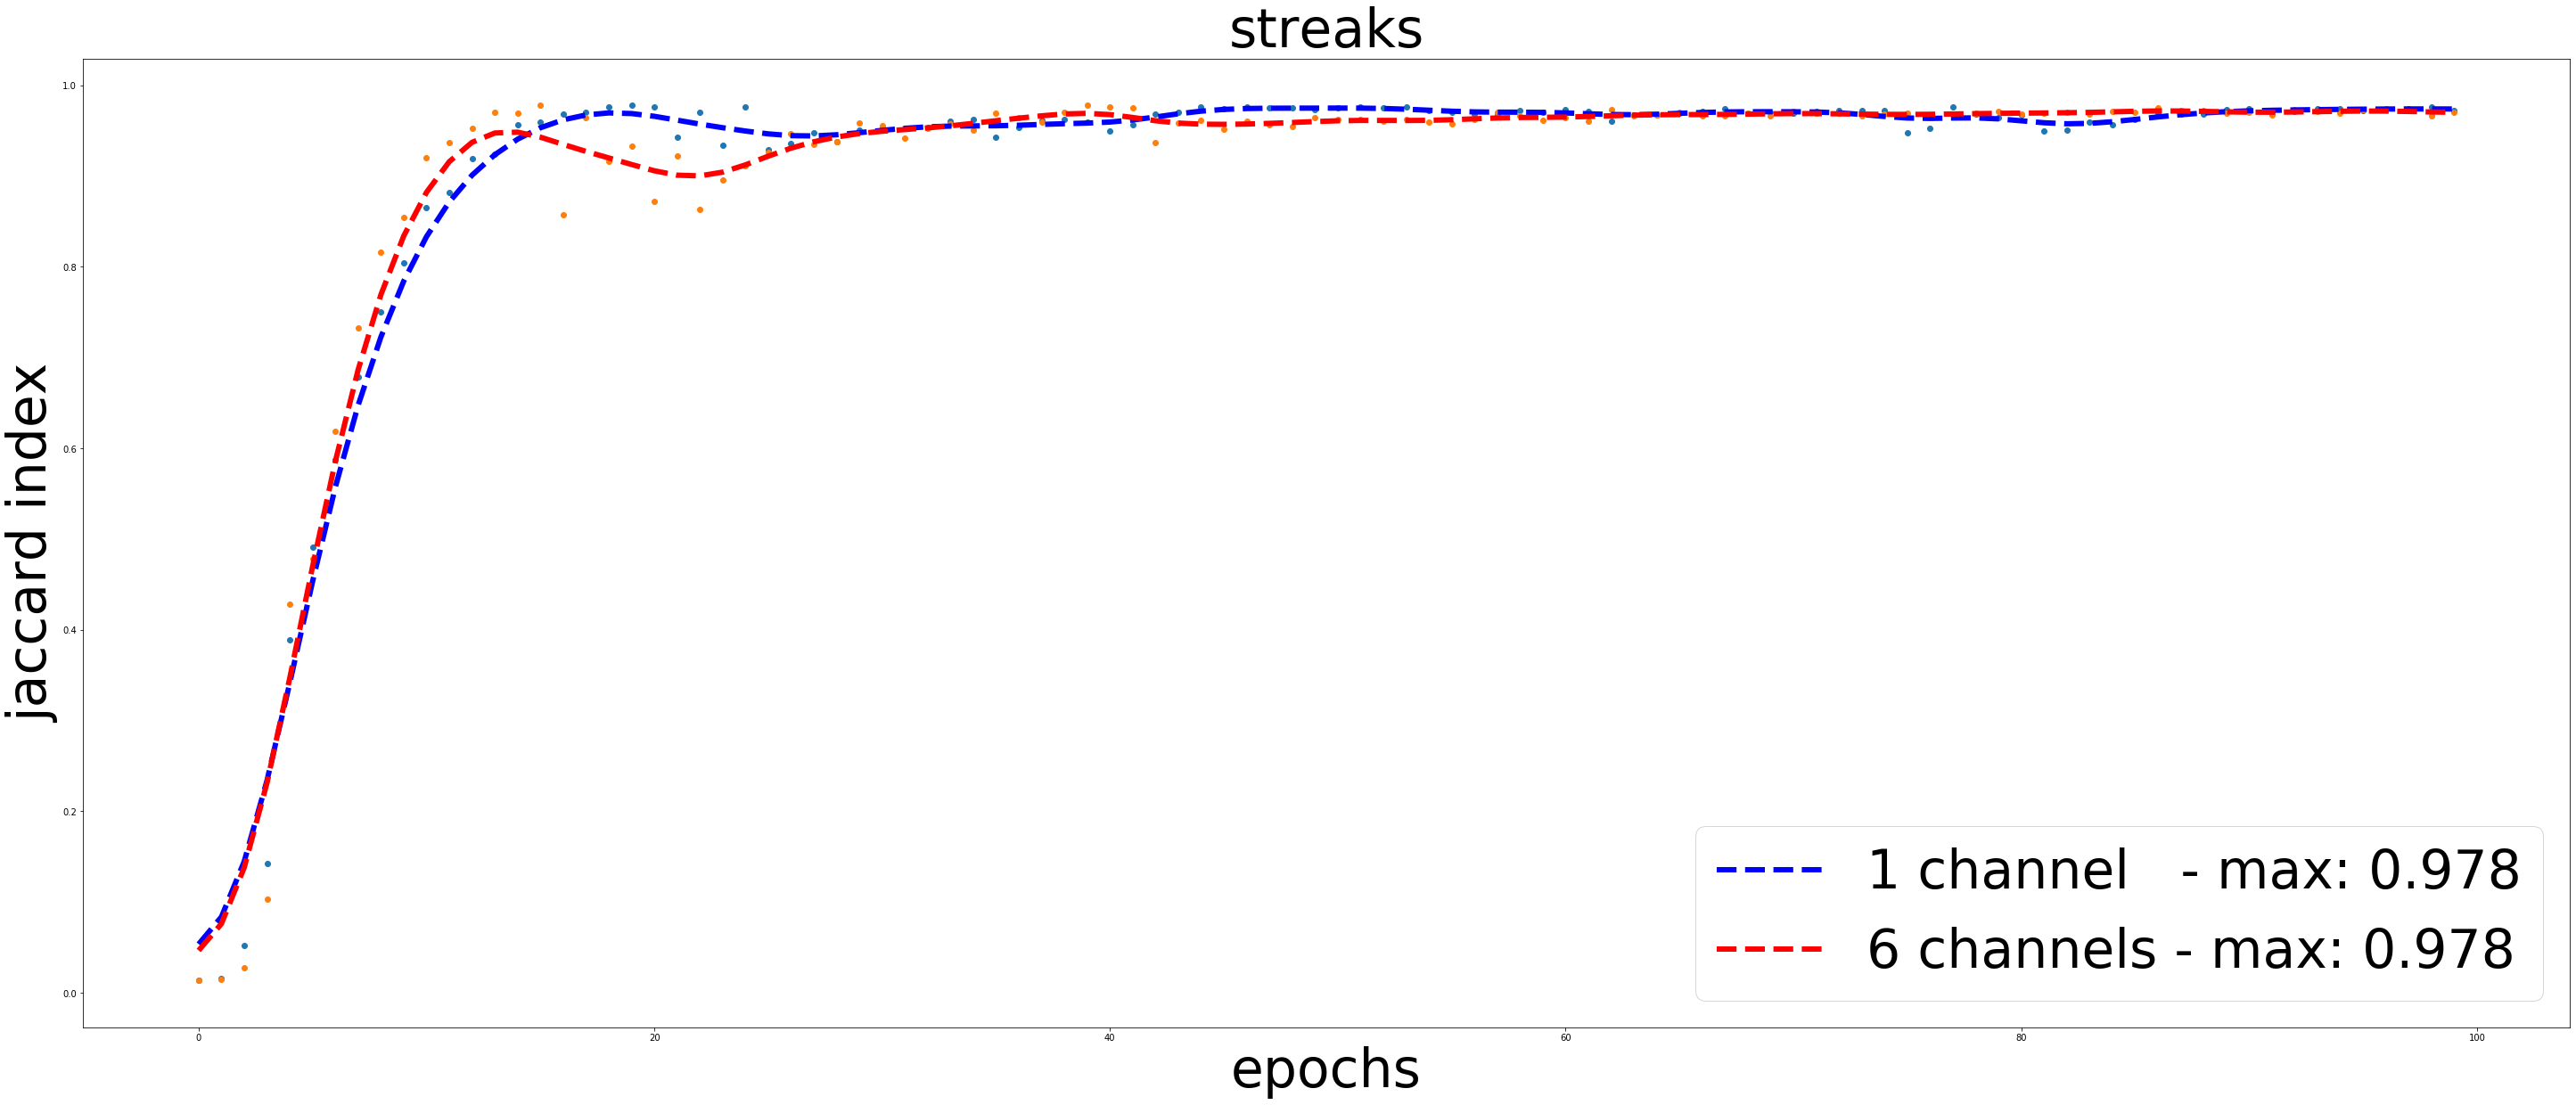

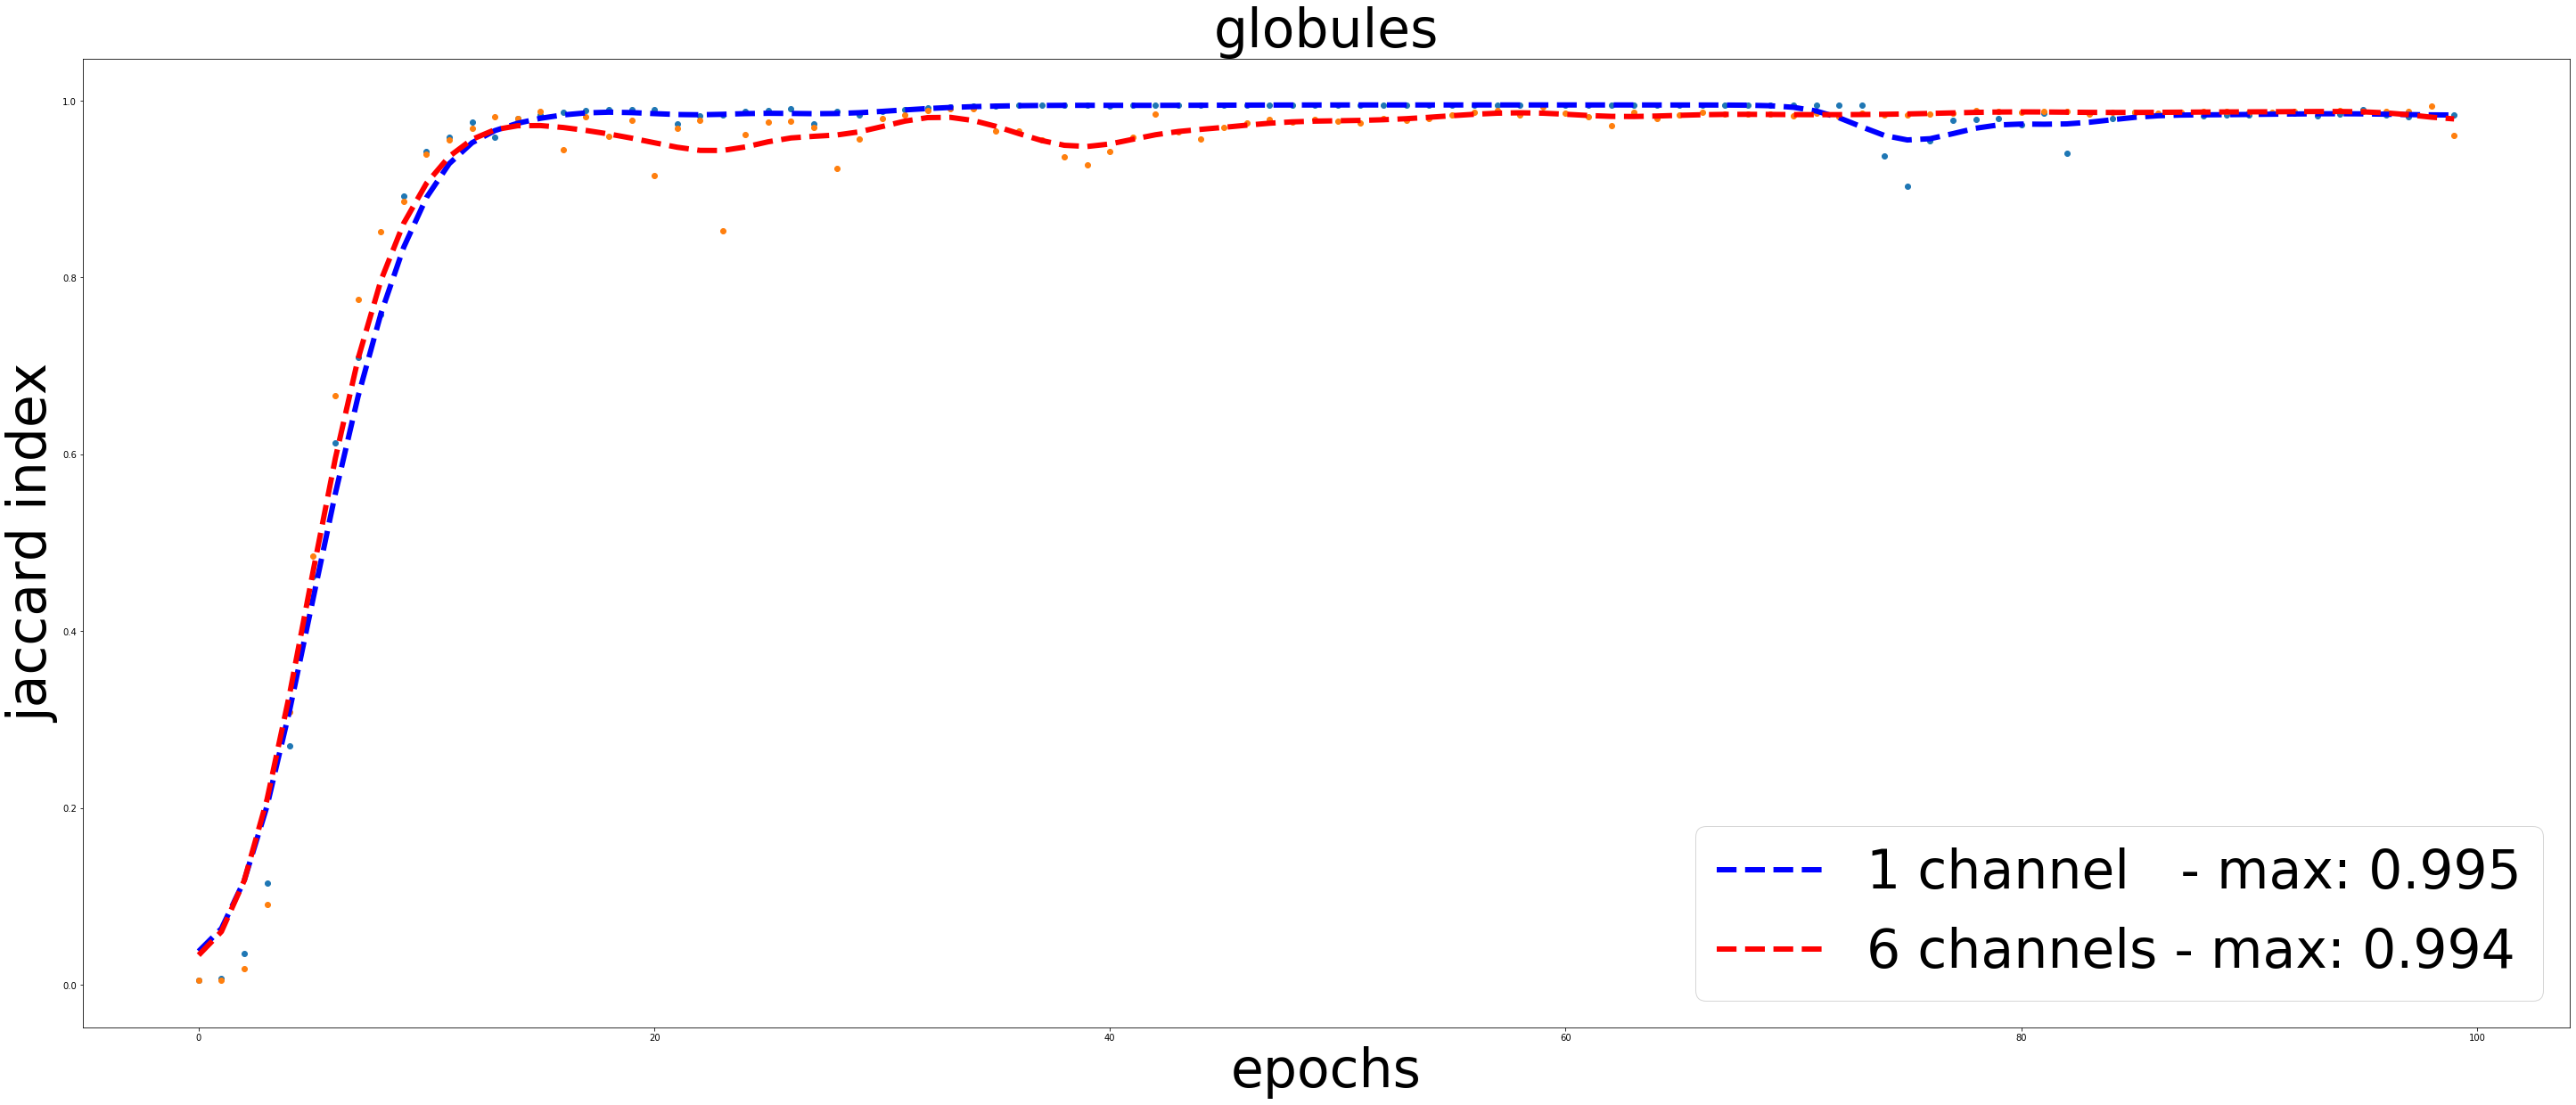

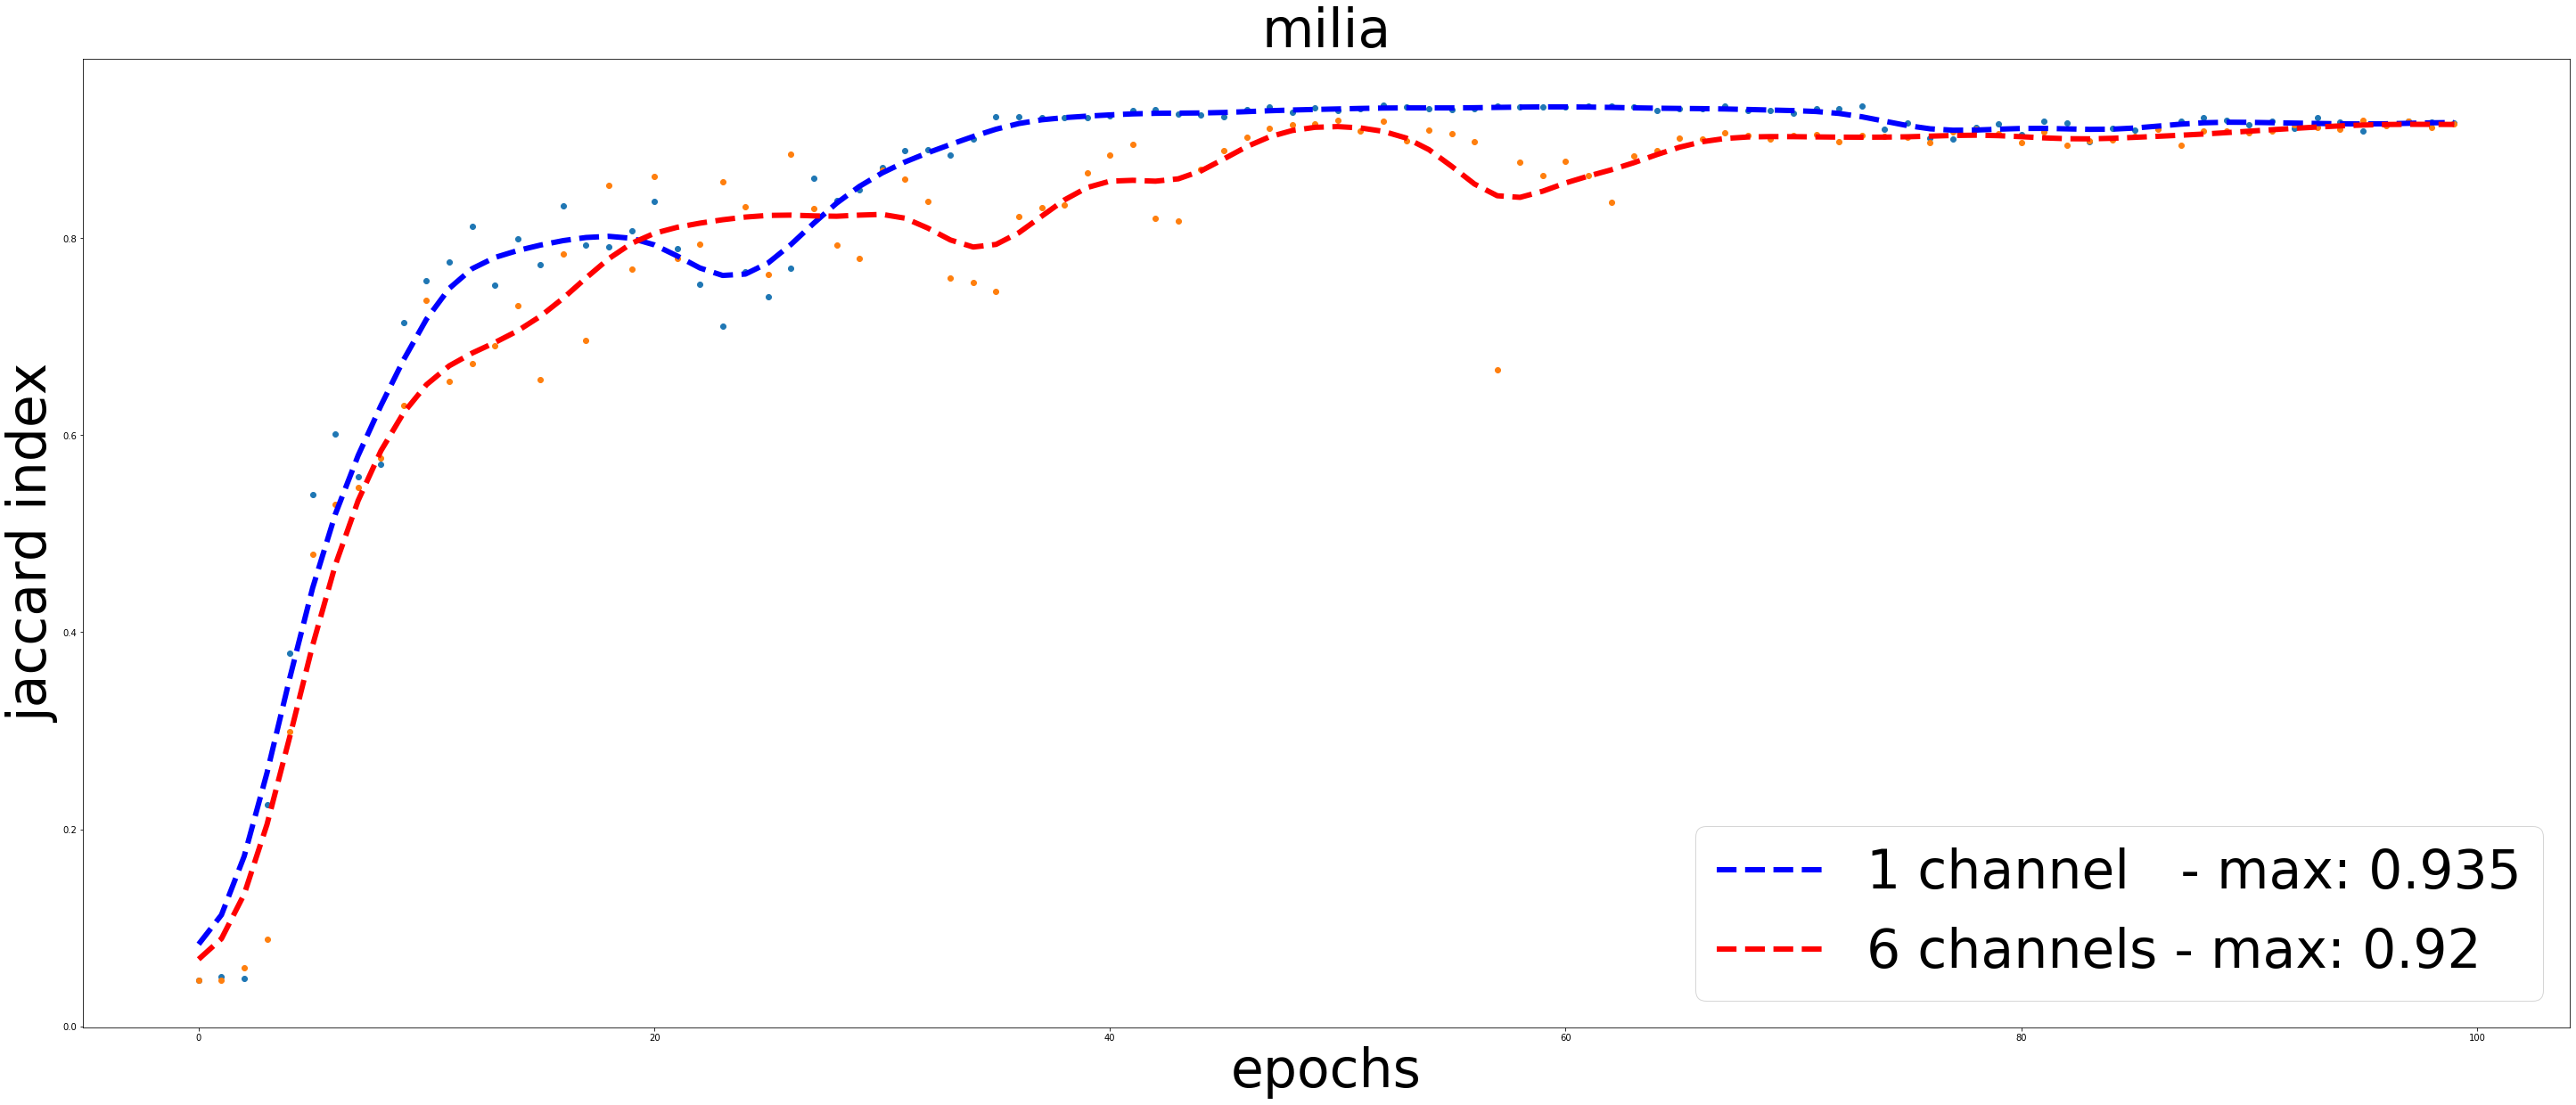

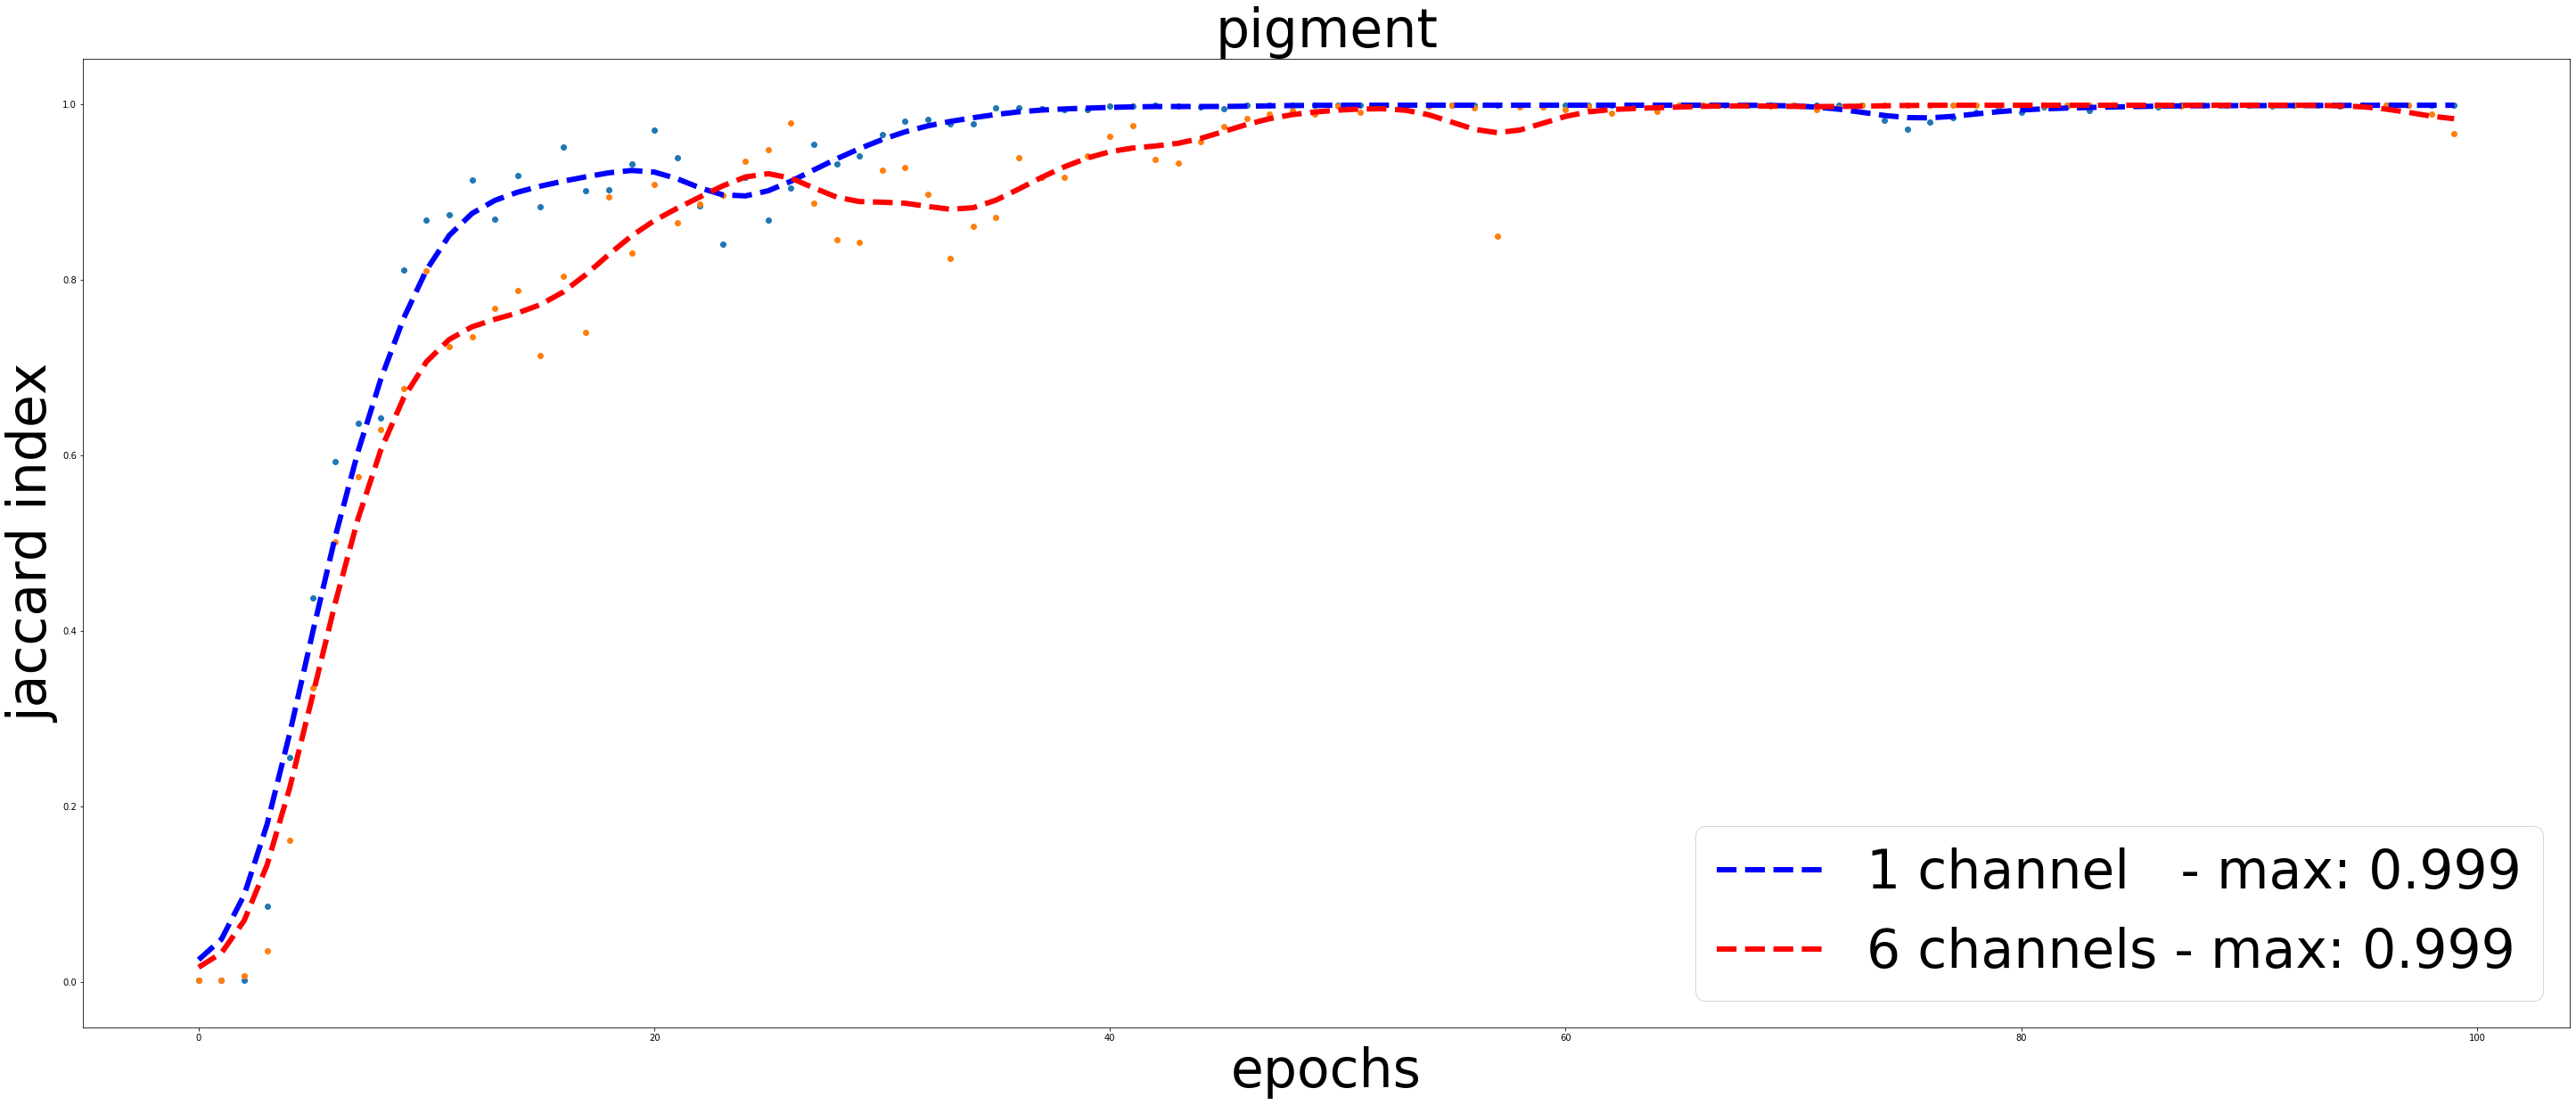

In [ ]:
for idx,jaccard_idx in enumerate(jaccard_atribute_1):
    fig = plt.figure(figsize=(50,20))
    n_epochs = 100
    jaccard_idx = jaccard_idx[0:100]
    plt.scatter(range(0,n_epochs),jaccard_atribute_1[idx])
    from scipy.ndimage.filters import gaussian_filter1d
    ysmoothed = gaussian_filter1d(jaccard_idx, sigma=2)
    plt.plot(range(0,n_epochs),ysmoothed,"b--",linewidth=6, markersize=12)
    jaccard_idx = jaccard_atribute_2[idx]
    plt.scatter(range(0,n_epochs),jaccard_atribute_2[idx])

    #z = np.polyfit(range(0,n_epochs), np.log(jaccard_idx),1)
    #p = np.poly1d(z)
    #plt.plot(range(0,n_epochs),np.exp(p(range(0,n_epochs))),"r--")
    
    from scipy.ndimage.filters import gaussian_filter1d
    ysmoothed = gaussian_filter1d(jaccard_idx, sigma=2)
    plt.plot(range(0,n_epochs),ysmoothed,"r--",linewidth=6, markersize=12)

    
    #fig.suptitle(targets[idx], fontsize=20)
    plt.xlabel('epochs', fontsize=60)
    plt.ylabel('jaccard index', fontsize=60)
    maxi_1 = str(round(np.max(jaccard_atribute_1[idx]),3))
    maxi_2 = str(round(np.max(jaccard_atribute_2[idx]),3))
    plt.legend(['1 channel   - max: '+maxi_1,'6 channels - max: '+maxi_2],fontsize=60)
    plt.title(targets[idx], fontsize=60)
    plt.show()
    fig.savefig(REPATH+TARGET+'_jaccard_COMPARATION_1_TO_6'+targets[idx]+'.jpg')